In [1]:
from bioblue.transforms import *
from pathlib import Path
####
import bioblue
import pytorch_lightning as pl
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib ipympl
import ipywidgets as widget
import os
from omegaconf import DictConfig, OmegaConf, open_dict
from hydra.utils import instantiate

import shutil
from datetime import datetime

from typing import Mapping
from tqdm.notebook import tqdm
import wandb

import matplotlib

from bioblue.nb.load import load_from_dir, load_from_dir2, load_from_cfg


# %reload_ext autoreload
# %autoreload 2

# Unite All predictions

In [2]:

from pathlib import Path
import pandas as pd
import pandas as pd
import json
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

run_dirs = [
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-54-59_WL-Excentricity_noNumeric_class1_100epochs_run21'), 
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-55-02_WL-Excentricity_noNumeric_class1_100epochs_run22'), 
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-55-20_WL-Excentricity_noNumeric_class1_100epochs_run23'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-55-20_WL-Excentricity_noNumeric_class1_100epochs_run24'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-55-20_WL-Excentricity_noNumeric_class1_100epochs_run25'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/21-55-20_WL-Excentricity_noNumeric_class1_100epochs_run26'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/22-33-05_WL-Excentricity_noNumeric_class1_100epochs_run27'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/22-36-36_WL-Excentricity_noNumeric_class1_100epochs_run28'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/22-51-29_WL-Excentricity_noNumeric_class1_100epochs_run29'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-06/22-52-11_WL-Excentricity_noNumeric_class1_100epochs_run30'),
 
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-04-00_WL-Excentricity_noNumeric_class1_100epochs_run31'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-04-00_WL-Excentricity_noNumeric_class1_100epochs_run32'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-04-02_WL-Excentricity_noNumeric_class1_100epochs_run33'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-04-02_WL-Excentricity_noNumeric_class1_100epochs_run34'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-46-54_WL-Excentricity_noNumeric_class1_100epochs_run35'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-59-33_WL-Excentricity_noNumeric_class1_100epochs_run36'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/00-59-38_WL-Excentricity_noNumeric_class1_100epochs_run37'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/01-19-52_WL-Excentricity_noNumeric_class1_100epochs_run38'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/01-29-30_WL-Excentricity_noNumeric_class1_100epochs_run39'),
Path('/home/ucl/elen/nsayez/bio-blueprints/outputs/2023-03-07/01-55-54_WL-Excentricity_noNumeric_class1_100epochs_run40'),

]

In [3]:

n_bins = 11
bins = np.linspace(0, 1, n_bins, endpoint=True)

angular_excentricity = pd.read_csv(run_dirs[0] / 'results' / 'angular_excentricity.csv' )
angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 

angular_excentricity.head()

angular_excentricity
0              0.114704
1              0.254952
2              0.846746
3              0.266586
4              0.431081

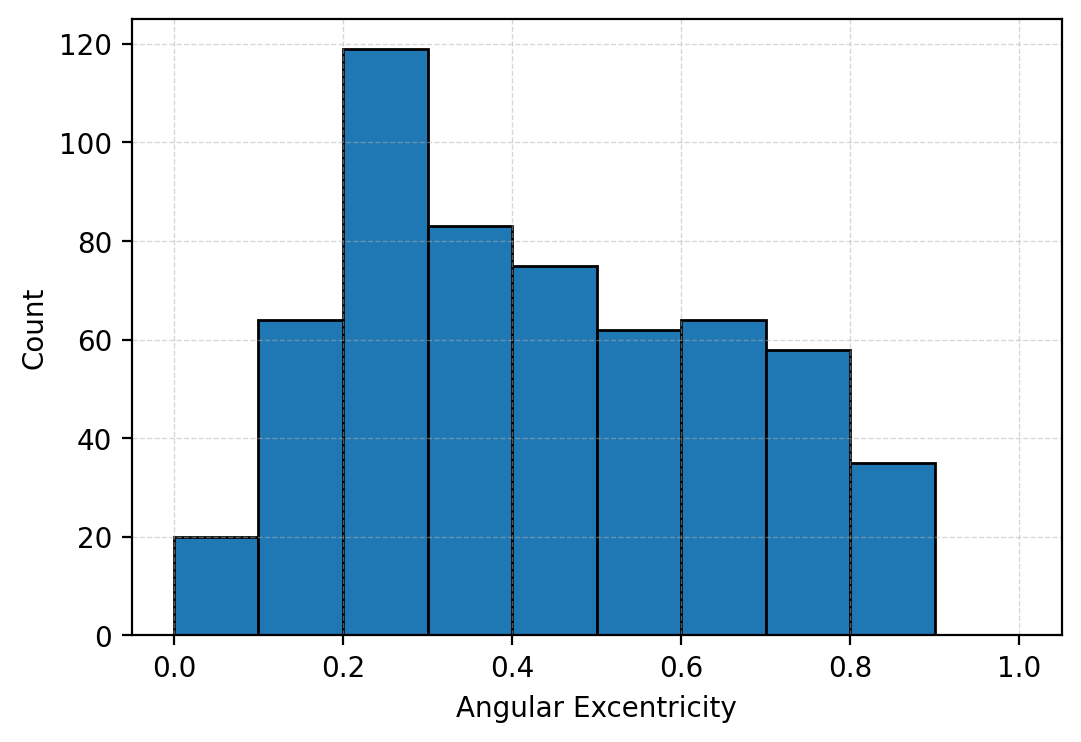

In [4]:
f,a = plt.subplots(nrows=1,ncols=1,figsize=(6,4),dpi=200)
# a.hist(all_ang_excentricity, bins=bins, ec='black', label='All')
angular_excentricity.hist(bins=bins, ax=a, ec='black')
a.set_title(None)
a.set_xlabel('Angular Excentricity')
a.set_ylabel('Count')
a.grid(linestyle='--', linewidth=0.5, alpha=0.5)
f.show()

In [5]:


huge_dict = {}

with open(run_dirs[0] / 'results' / 'mappers.json', 'r') as f:
    mapper = json.load(f)
    
inverted_mapper = {
                     'inv_c1':   {str(v): k  for k,v in mapper['used_c1'].items() },
                     'inv_c2':   {str(v): k  for k,v in mapper['used_c2'].items() },
                     'inv_c3':   {str(v): k  for k,v in mapper['used_c3'].items() },
                    }
print(mapper)
print(inverted_mapper)

run_ids = [int(str(run_dir)[-2:]) for run_dir in run_dirs]

#code for y1
total_y1_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_1 = pd.read_csv(run_dir / 'results' / 'y1.csv' )
    yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y1_pred["GT"] = yt_1[['y1_true']]

    total_y1_pred[f'run_{run_id}'] =  yt_1['y1_pred']


#code for y2
total_y2_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_2 = pd.read_csv(run_dir / 'results' / 'y2.csv' )
    yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y2_pred["GT"] = yt_2[['y2_true']]

    total_y2_pred[f'run_{run_id}'] =  yt_2['y2_pred']

#code for y3
total_y3_pred = pd.DataFrame()
for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    yt_3 = pd.read_csv(run_dir / 'results' / 'y3.csv' )
    yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')] 

    if i == 0:
        total_y3_pred["GT"] = yt_3[['y3_true']]

    total_y3_pred[f'run_{run_id}'] =  yt_3['y3_pred']

    

{'used_c1': {'A': 0, 'B': 1, 'C': 2, 'SuperGroup': 3, 'H': 4}, 'used_c2': {'x': 0, 'r': 1, 'sym': 2, 'asym': 3}, 'used_c3': {'x': 0, 'o': 1, 'frag': 2}}
{'inv_c1': {'0': 'A', '1': 'B', '2': 'C', '3': 'SuperGroup', '4': 'H'}, 'inv_c2': {'0': 'x', '1': 'r', '2': 'sym', '3': 'asym'}, 'inv_c3': {'0': 'x', '1': 'o', '2': 'frag'}}


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

(10, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   run_21  9 non-null      float64
 1   run_22  9 non-null      float64
 2   run_23  9 non-null      float64
 3   run_24  9 non-null      float64
 4   run_25  9 non-null      float64
 5   run_26  9 non-null      float64
 6   run_27  9 non-null      float64
 7   run_28  9 non-null      float64
 8   run_29  9 non-null      float64
 9   run_30  9 non-null      float64
 10  run_31  9 non-null      float64
 11  run_32  9 non-null      float64
 12  run_33  9 non-null      float64
 13  run_34  9 non-null      float64
 14  run_35  9 non-null      float64
 15  run_36  9 non-null      float64
 16  run_37  9 non-null      float64
 17  run_38  9 non-null      float64
 18  run_39  9 non-null      float64
 19  run_40  9 non-null      float64
dtypes: float64(20)
memory usage: 1.7 KB


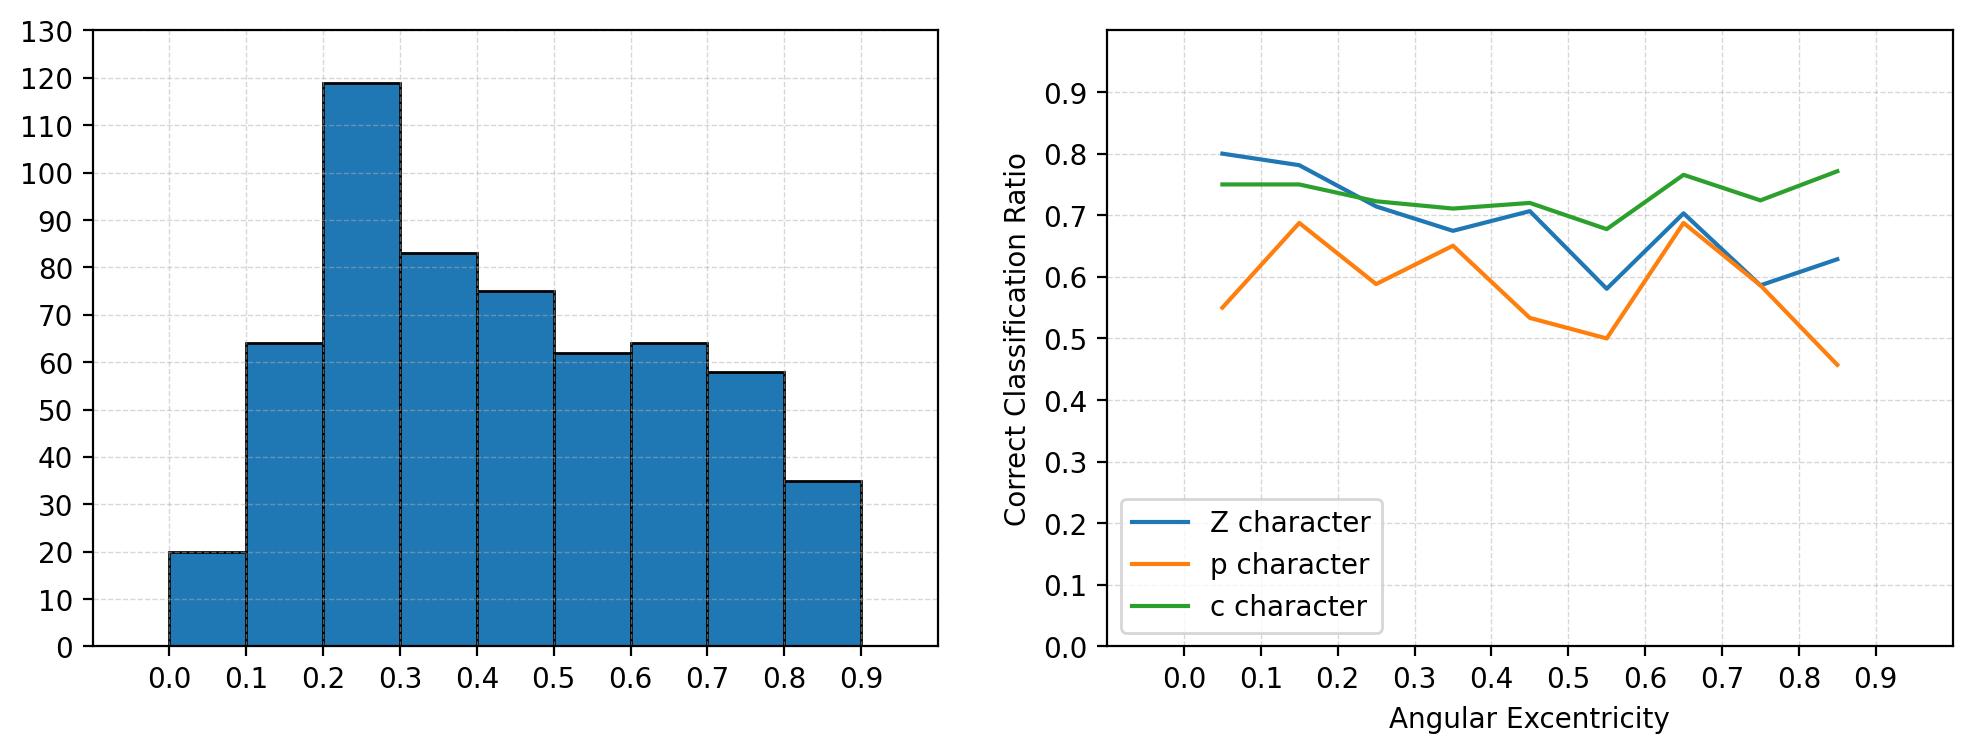

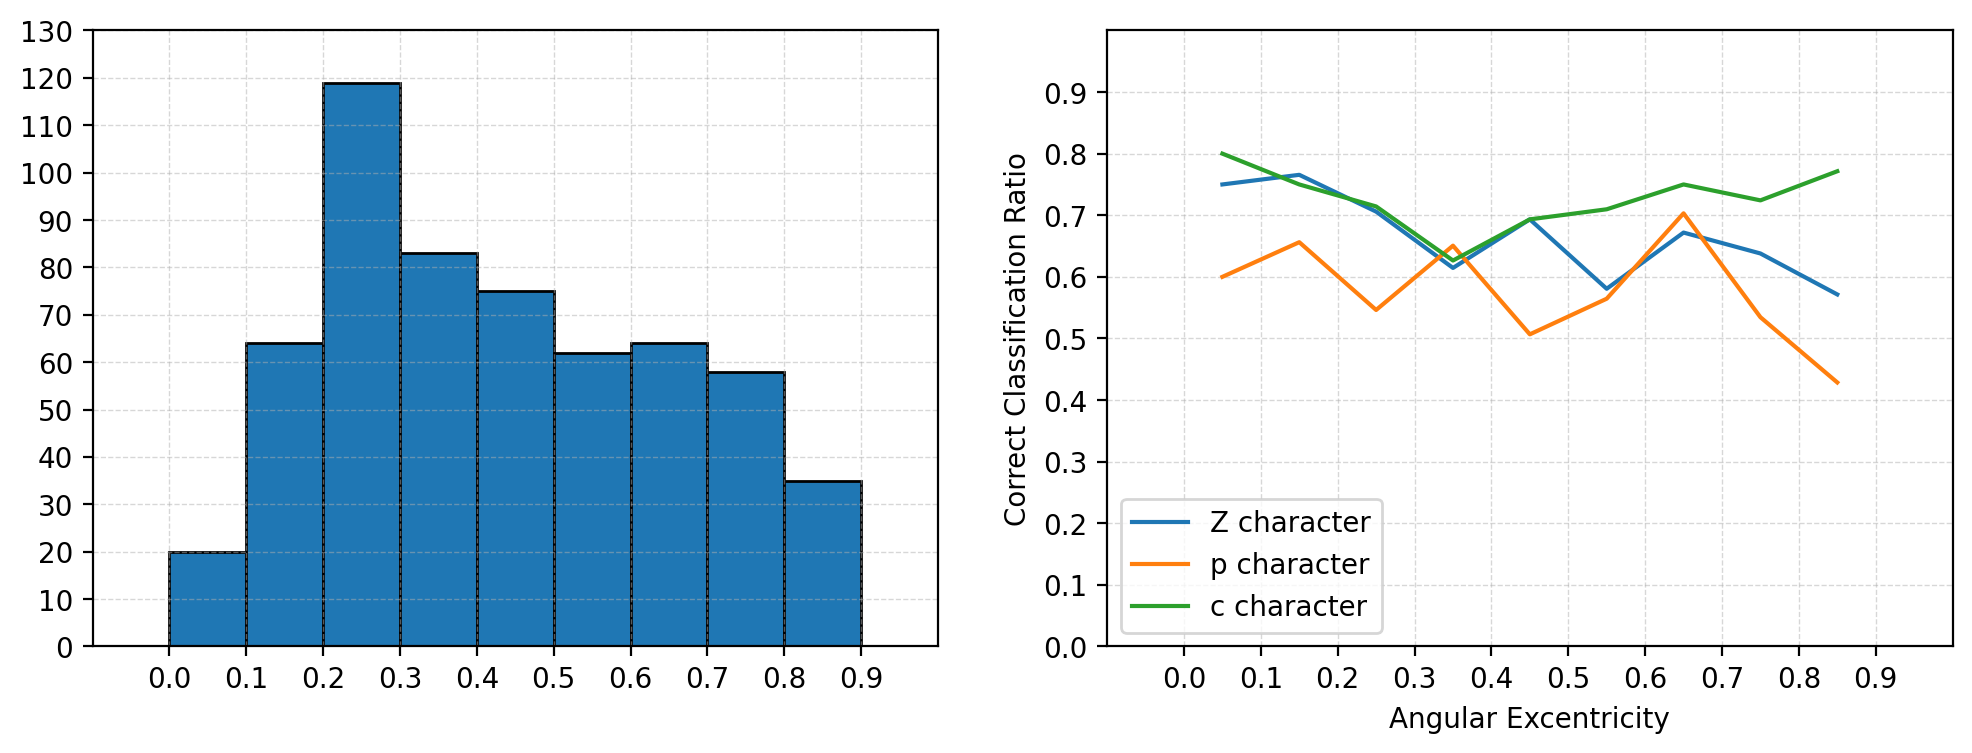

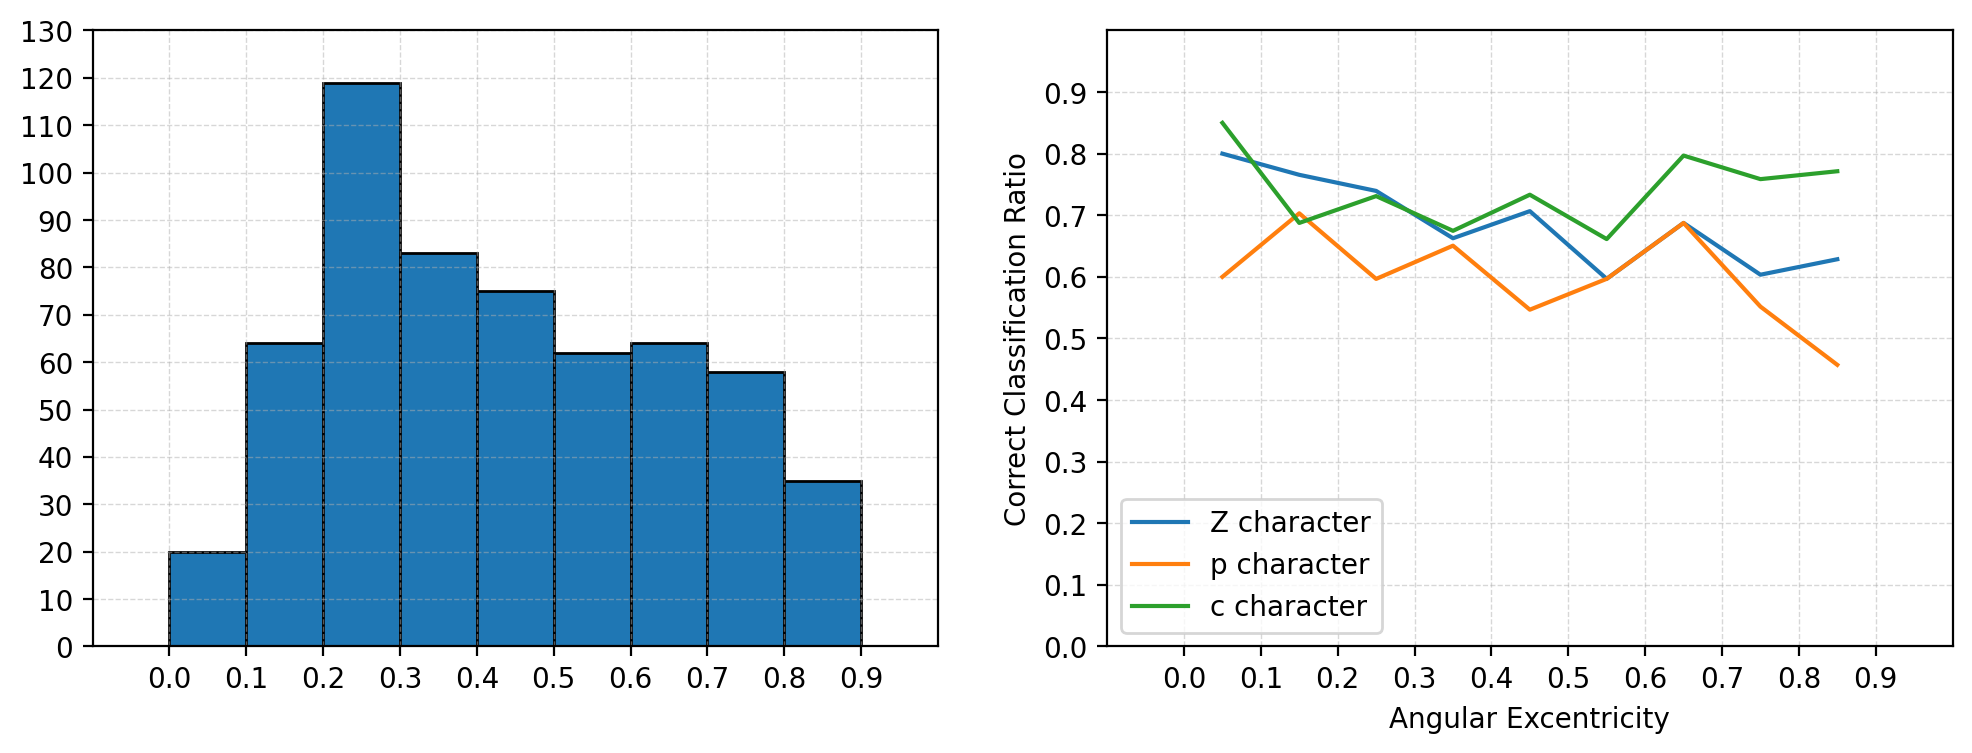

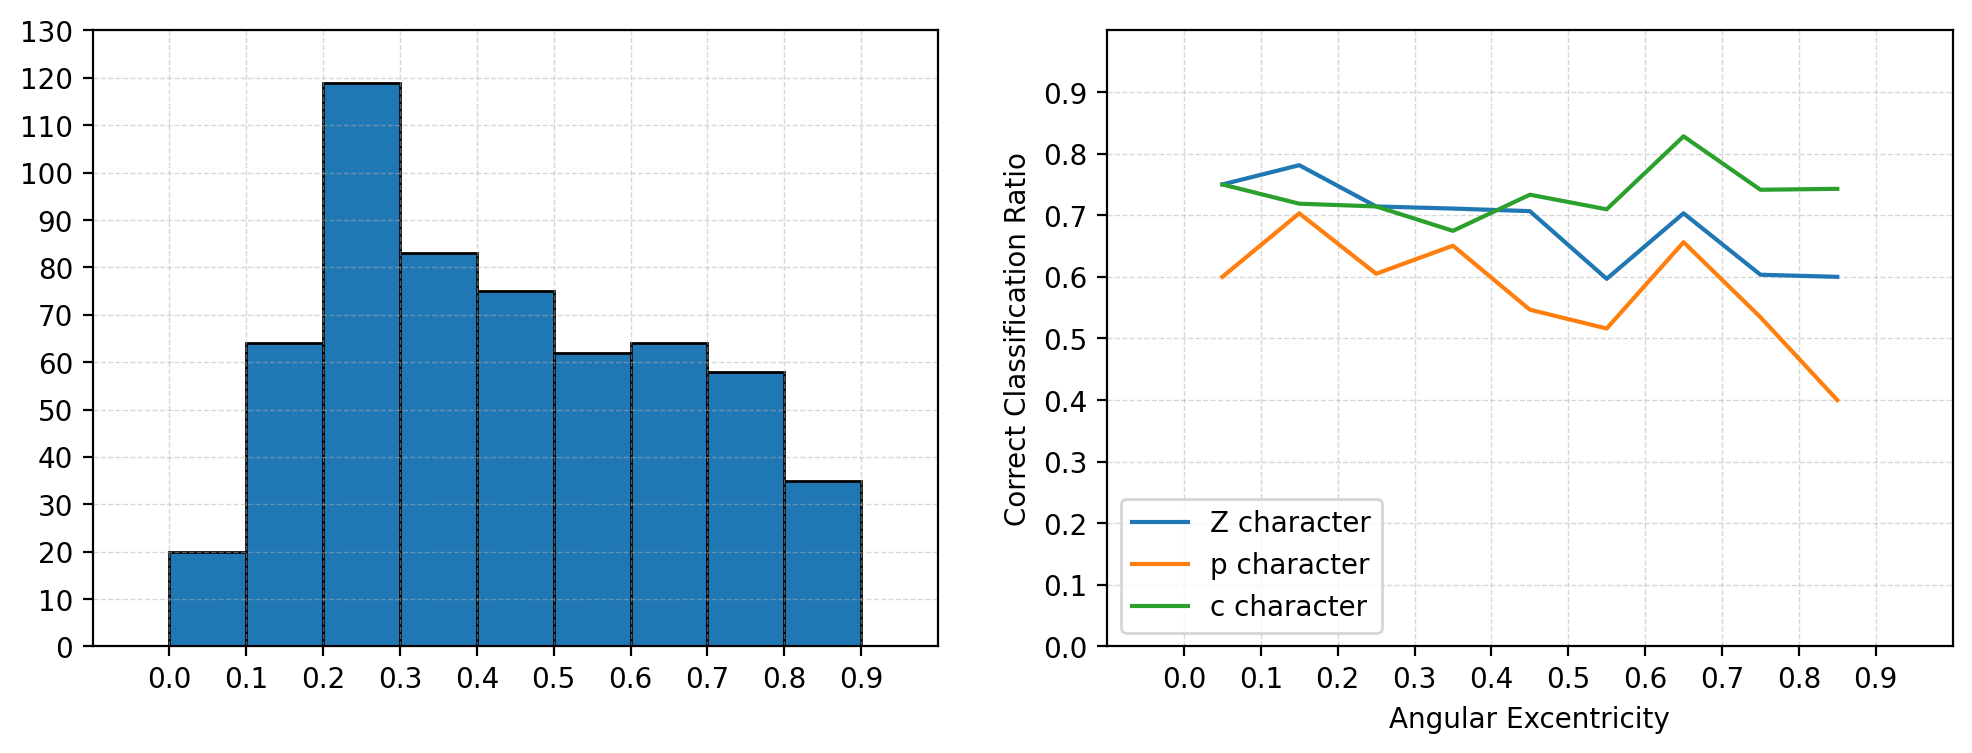

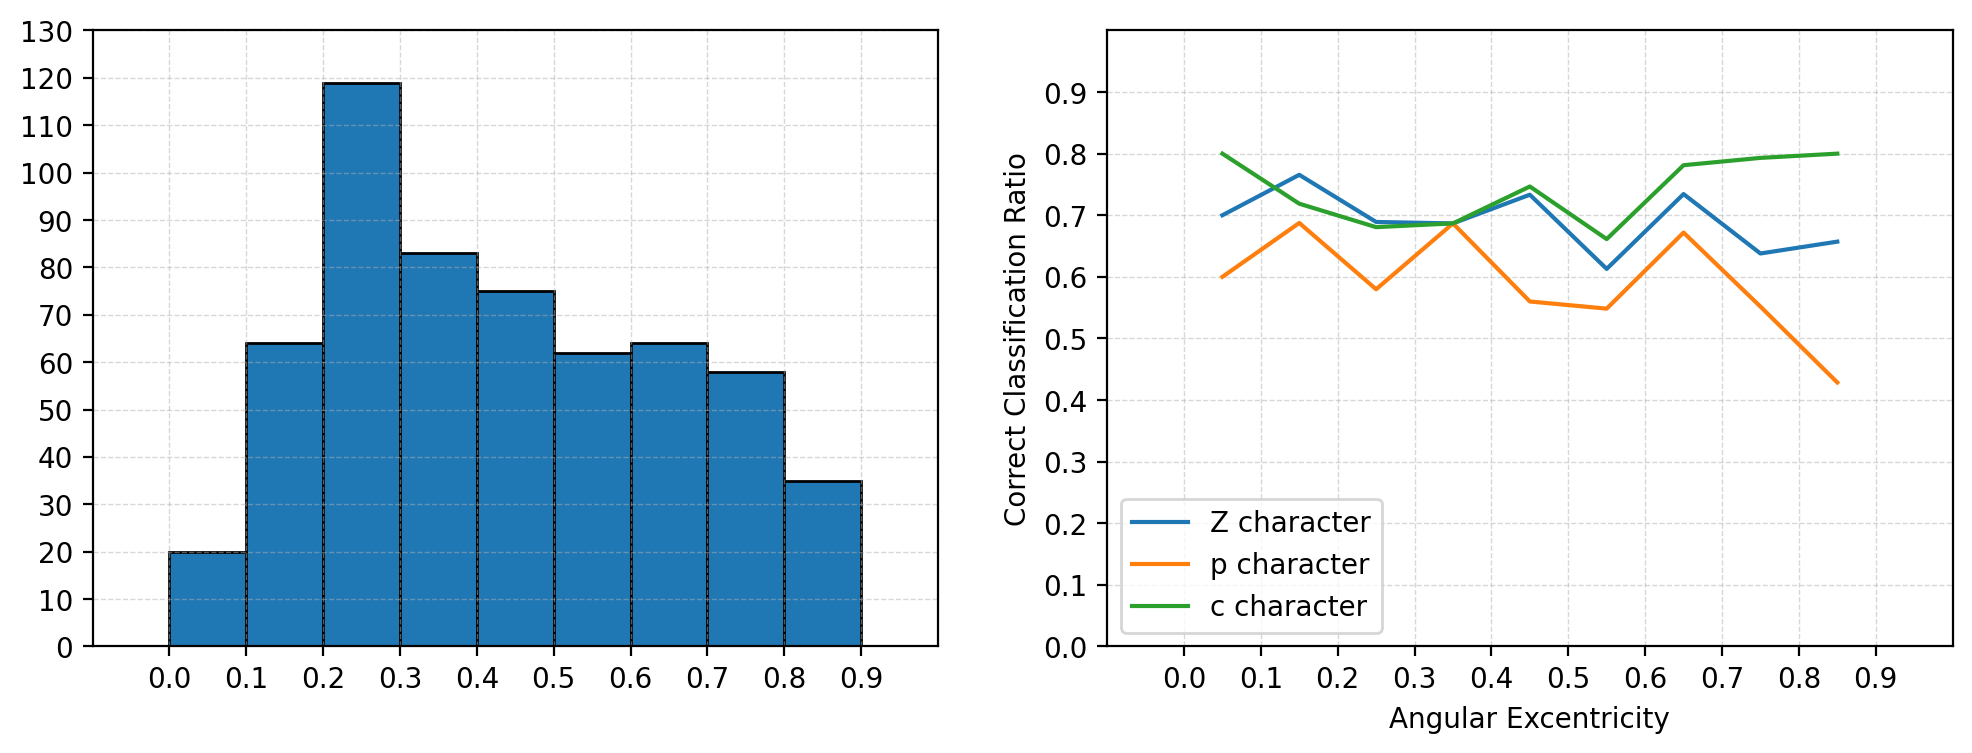

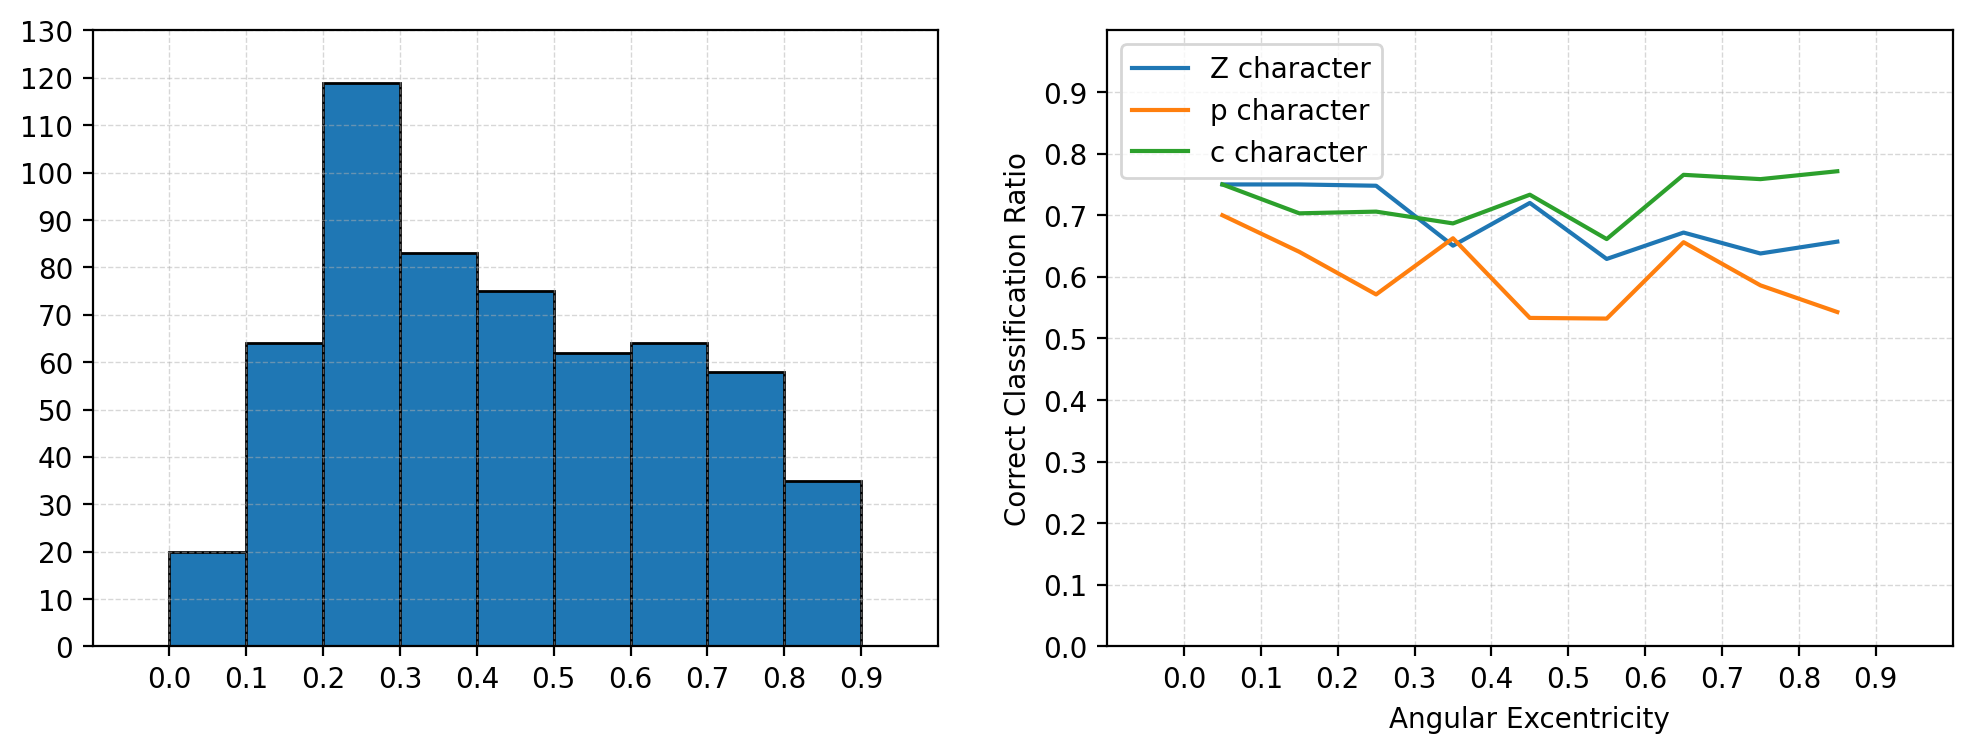

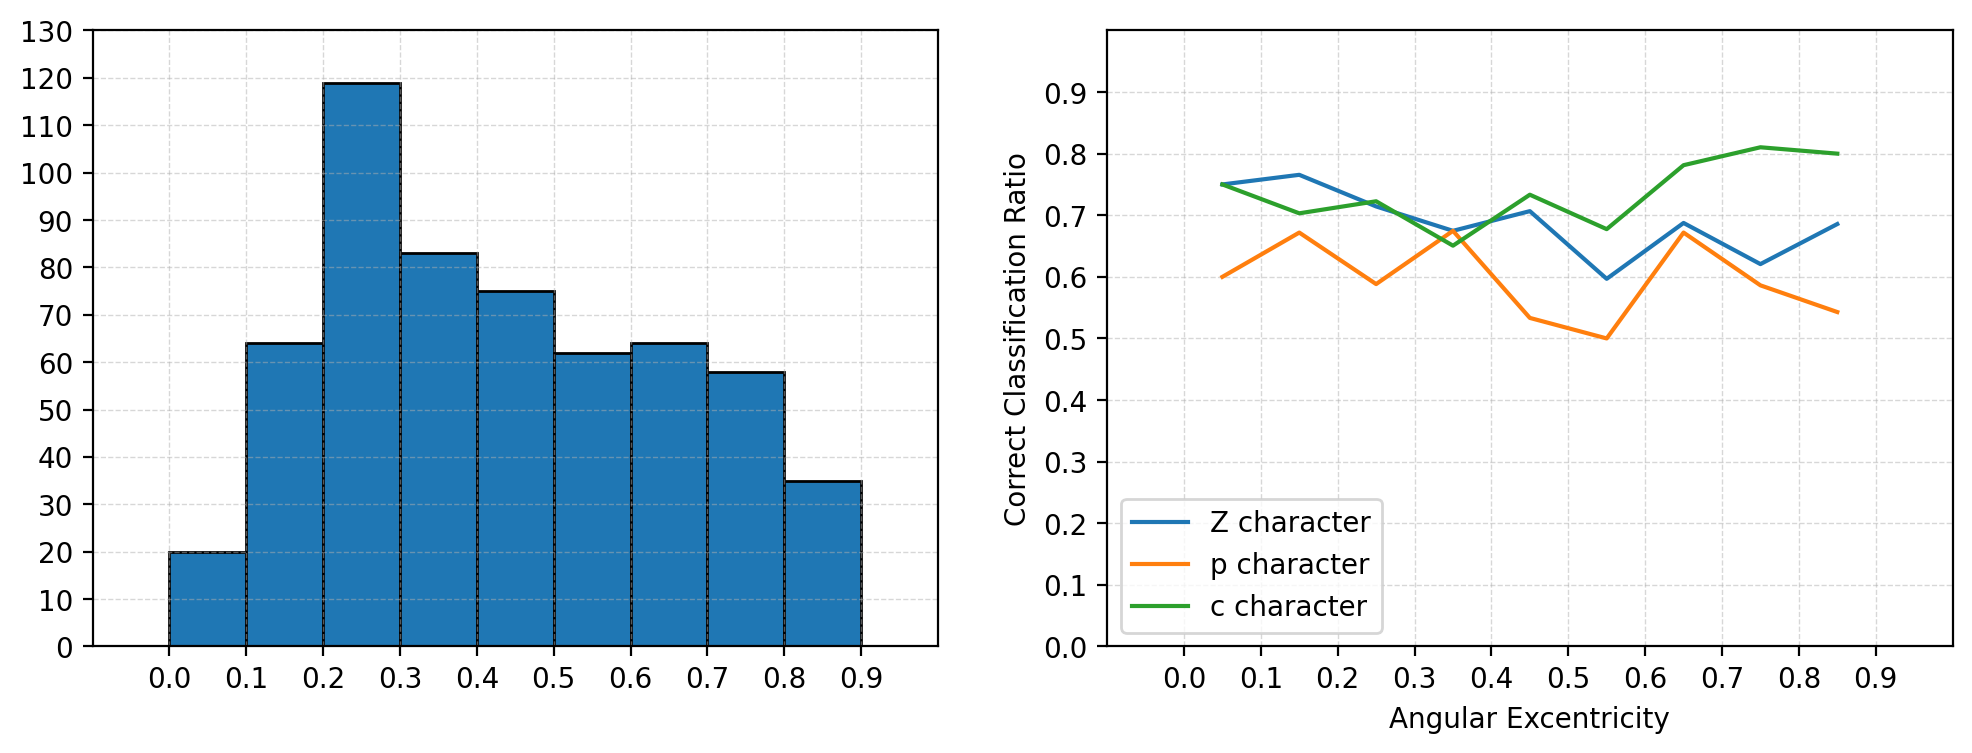

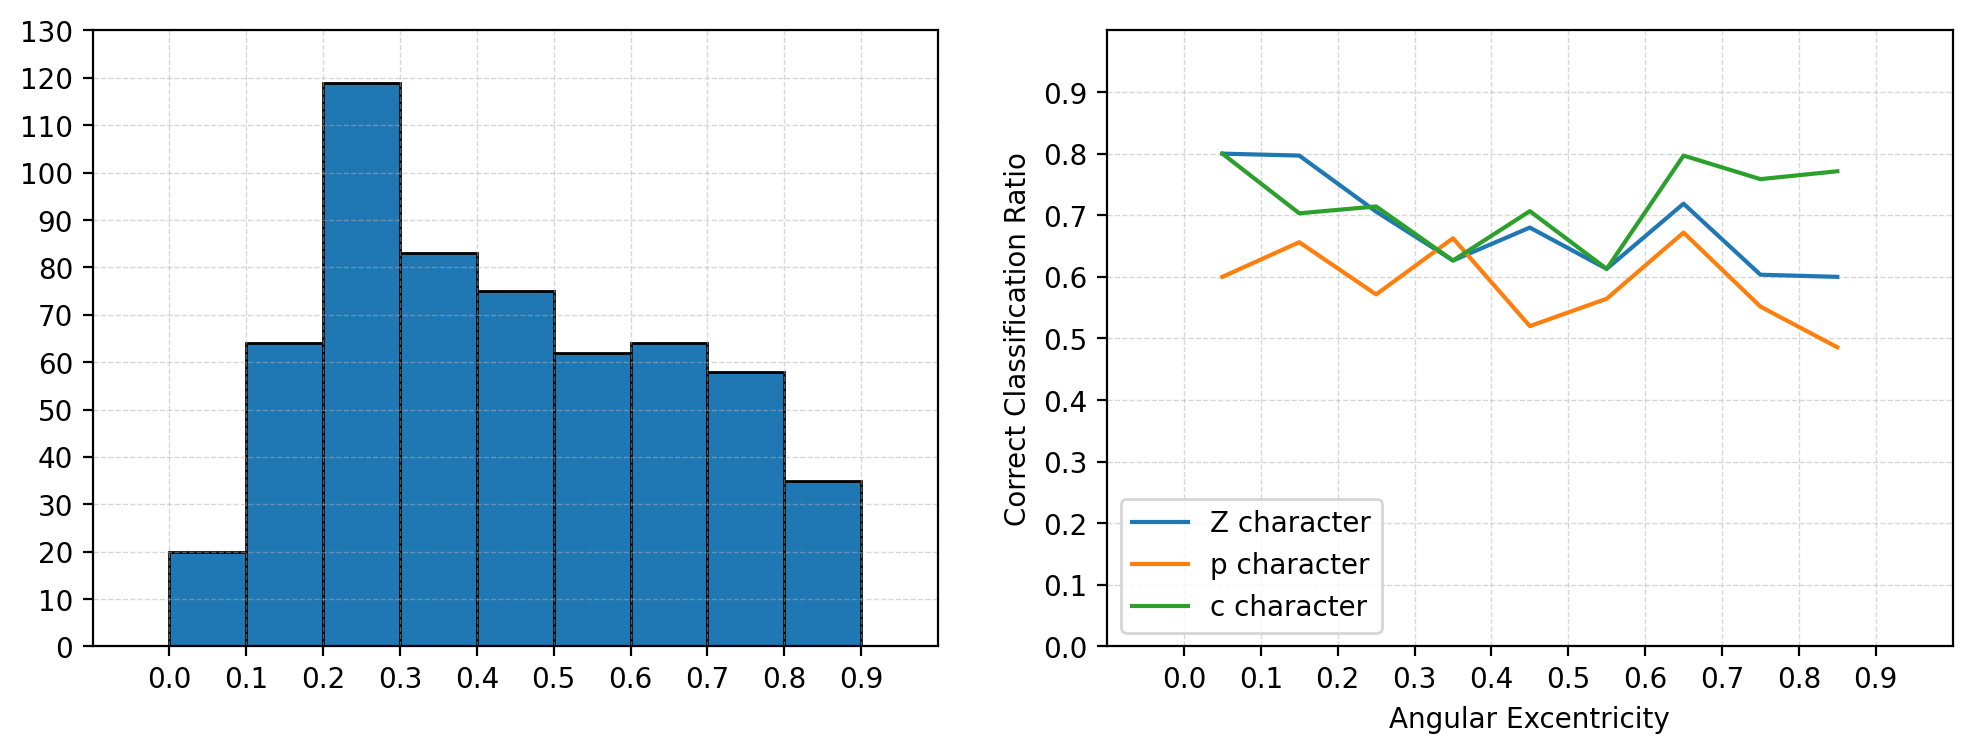

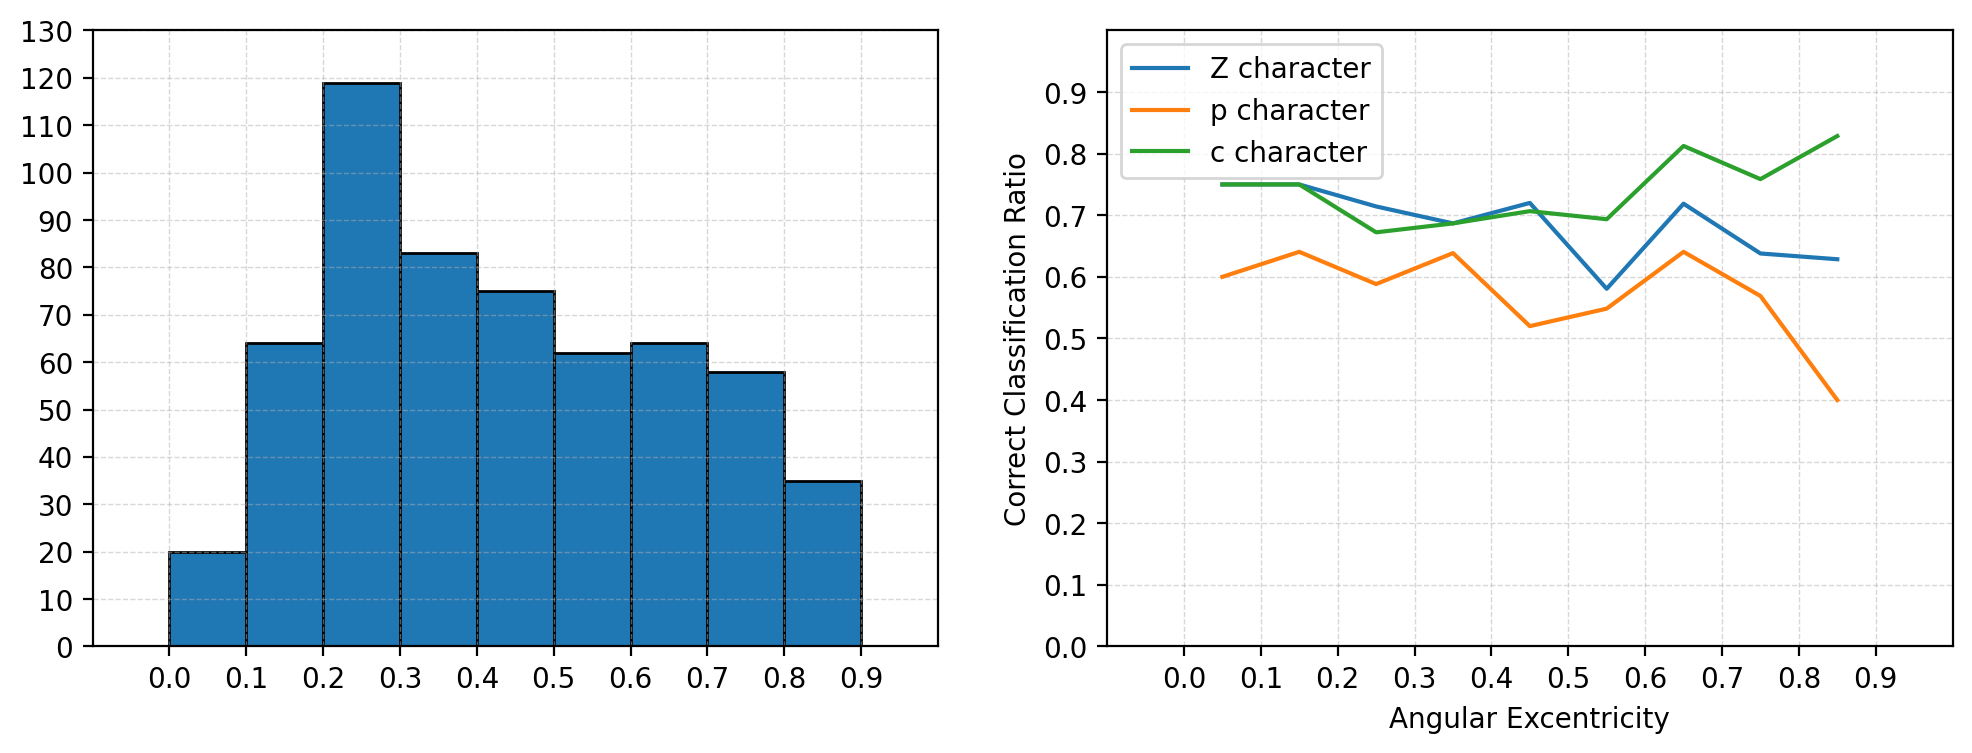

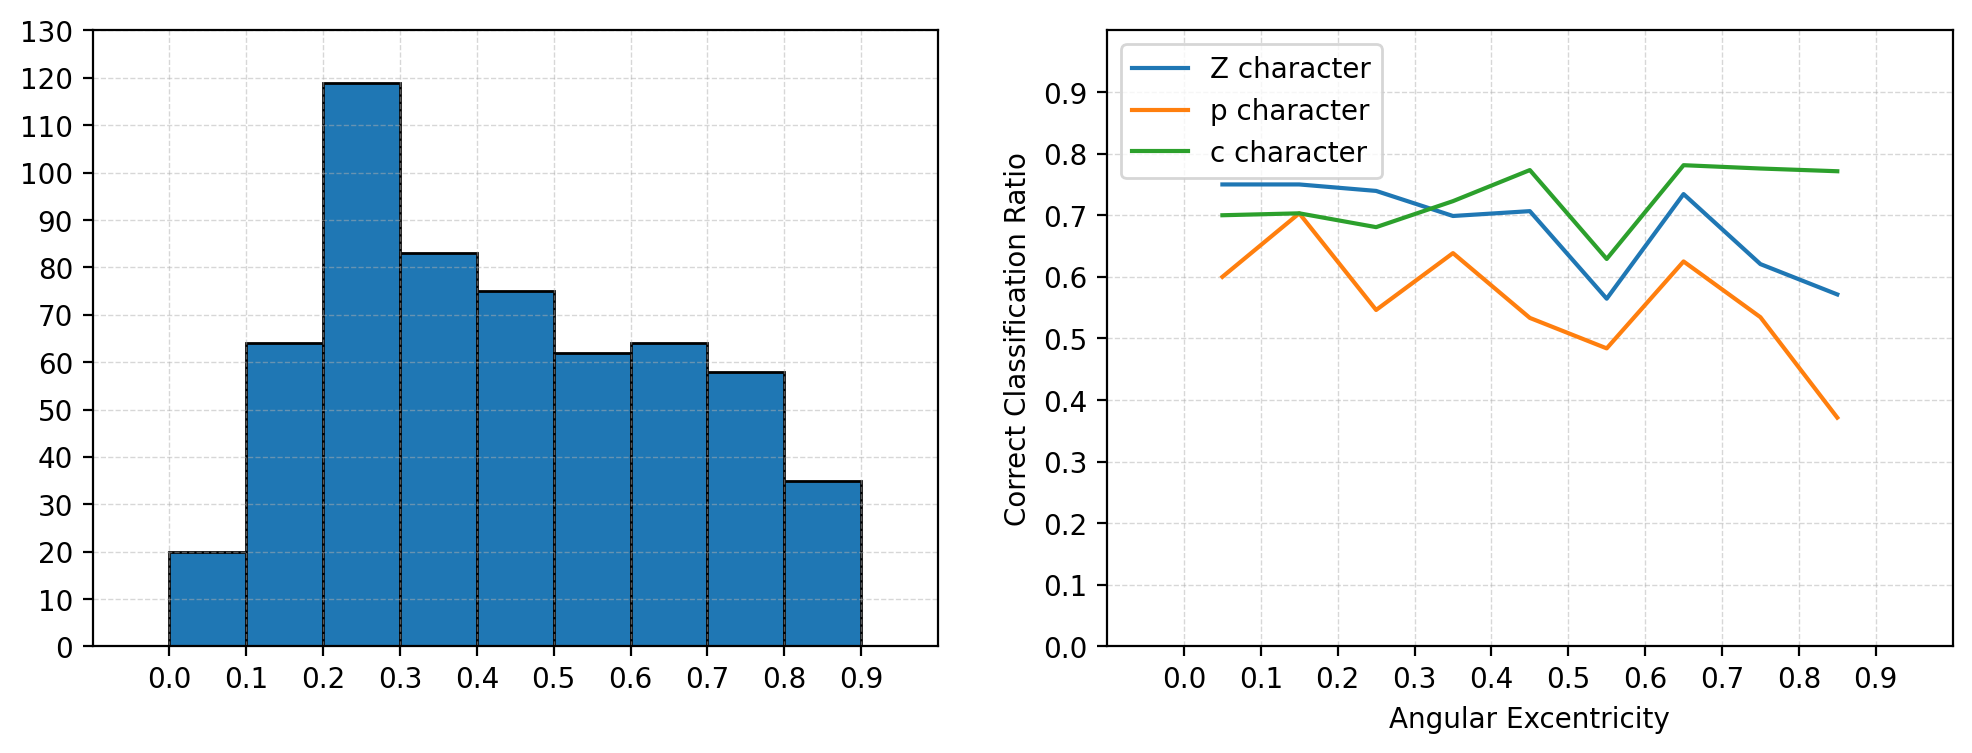

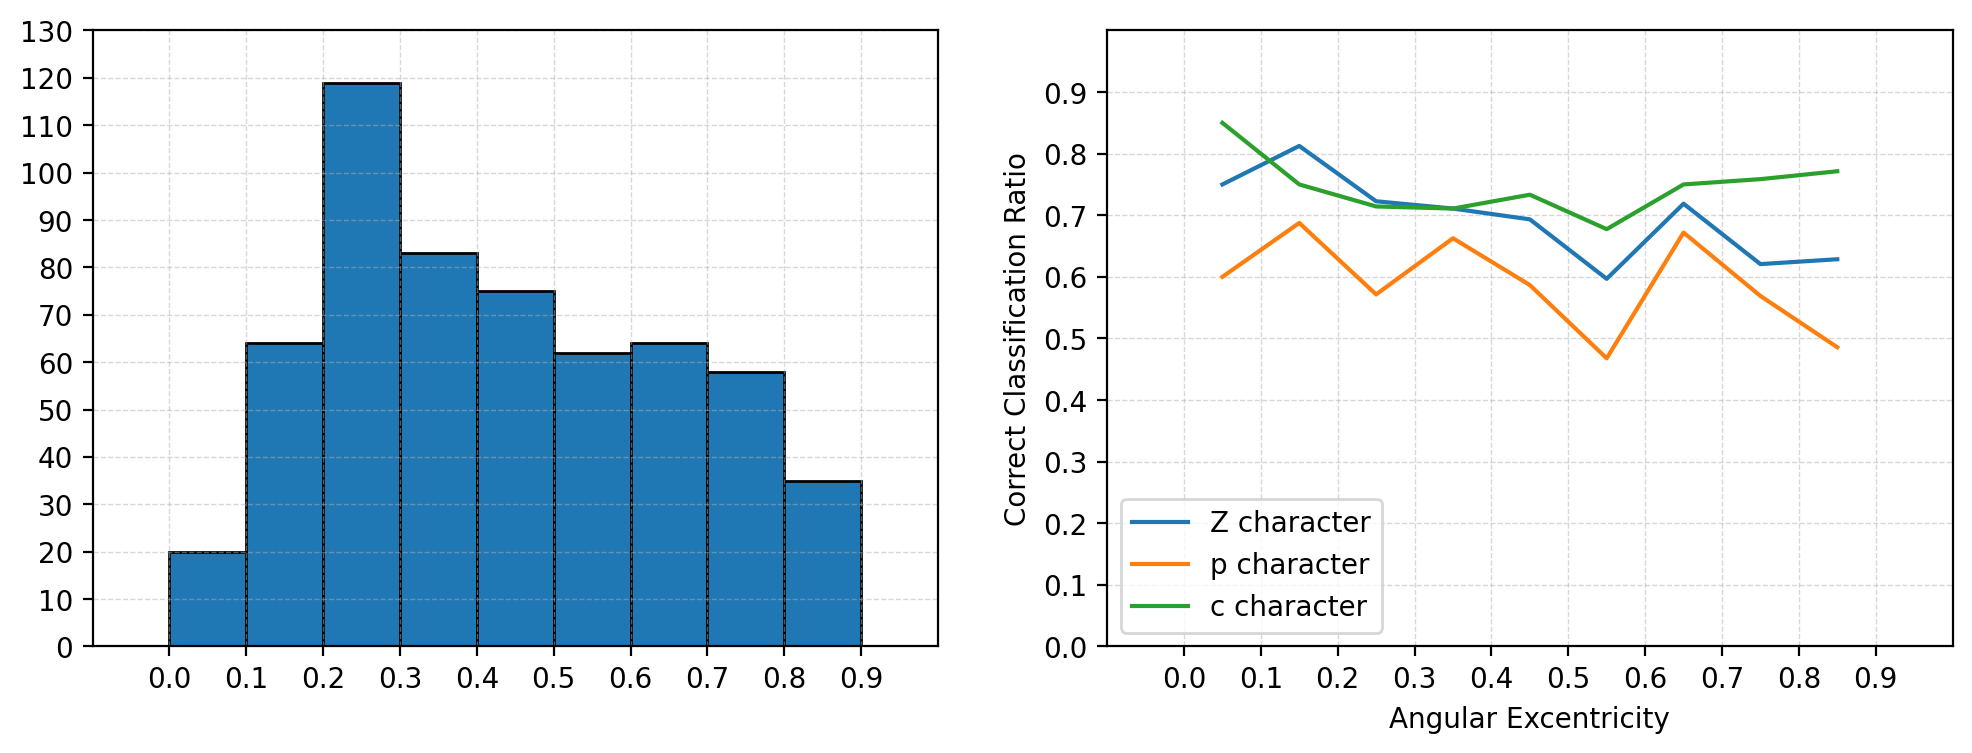

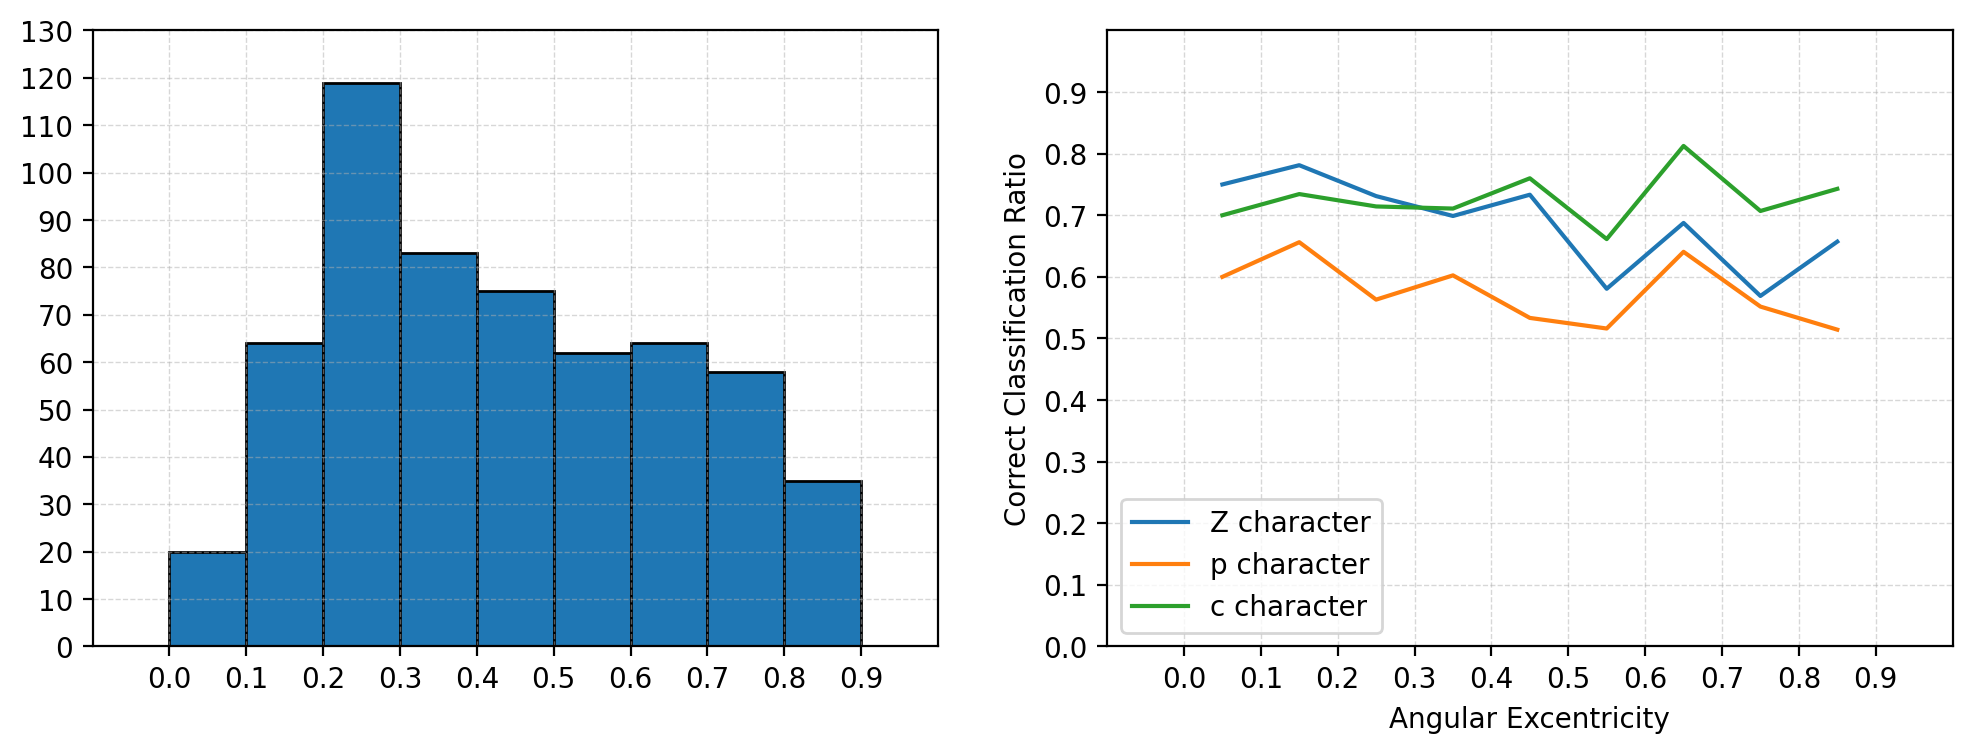

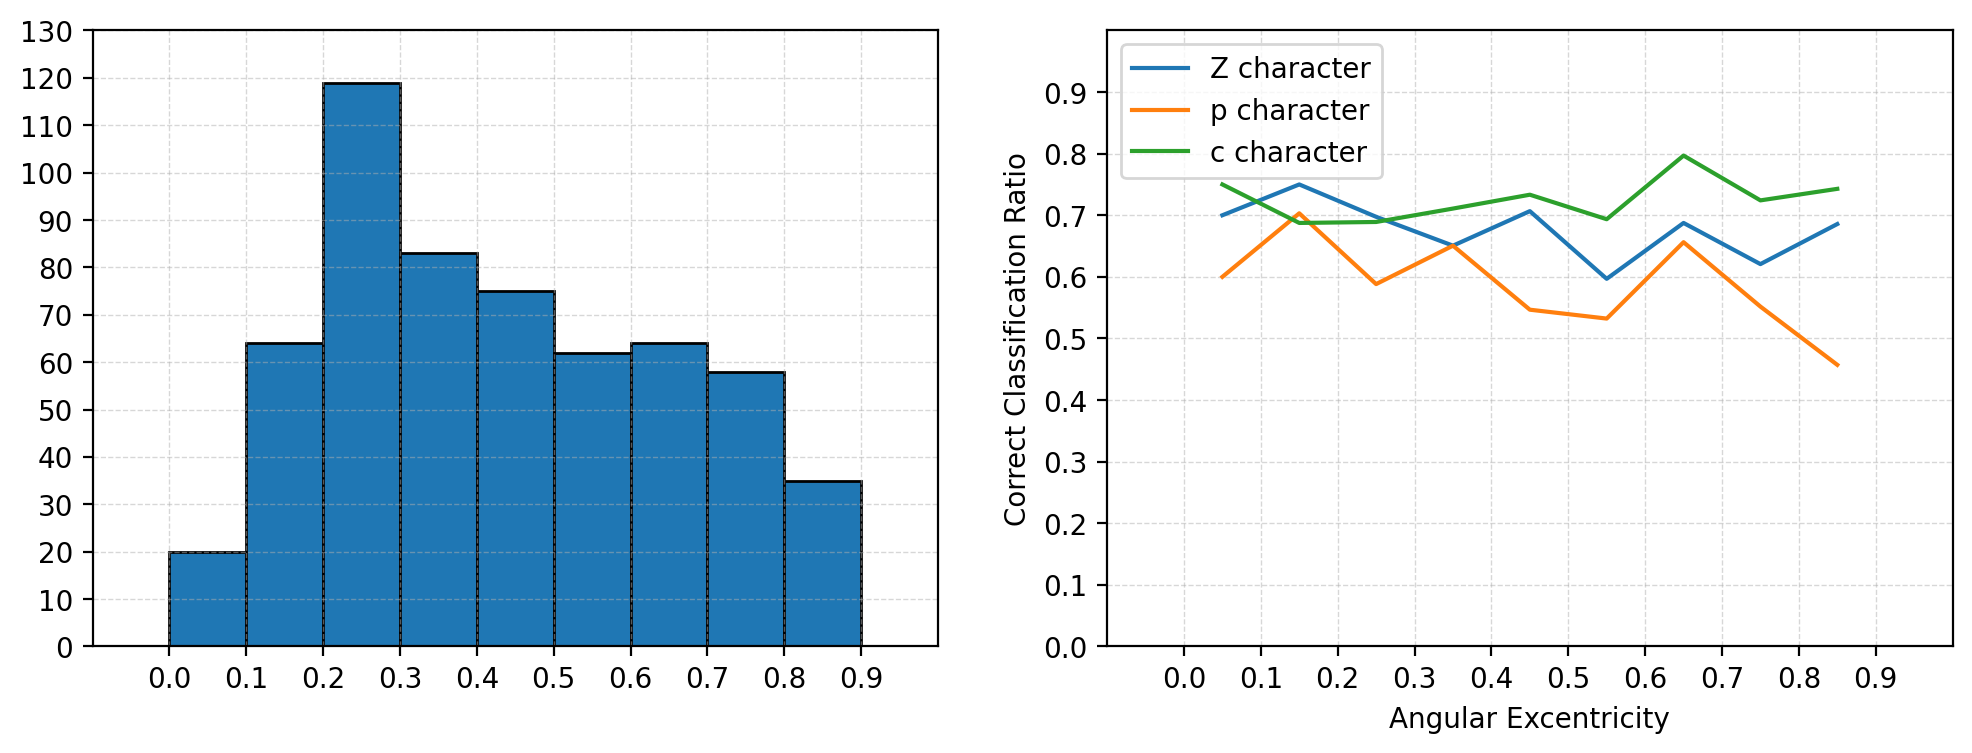

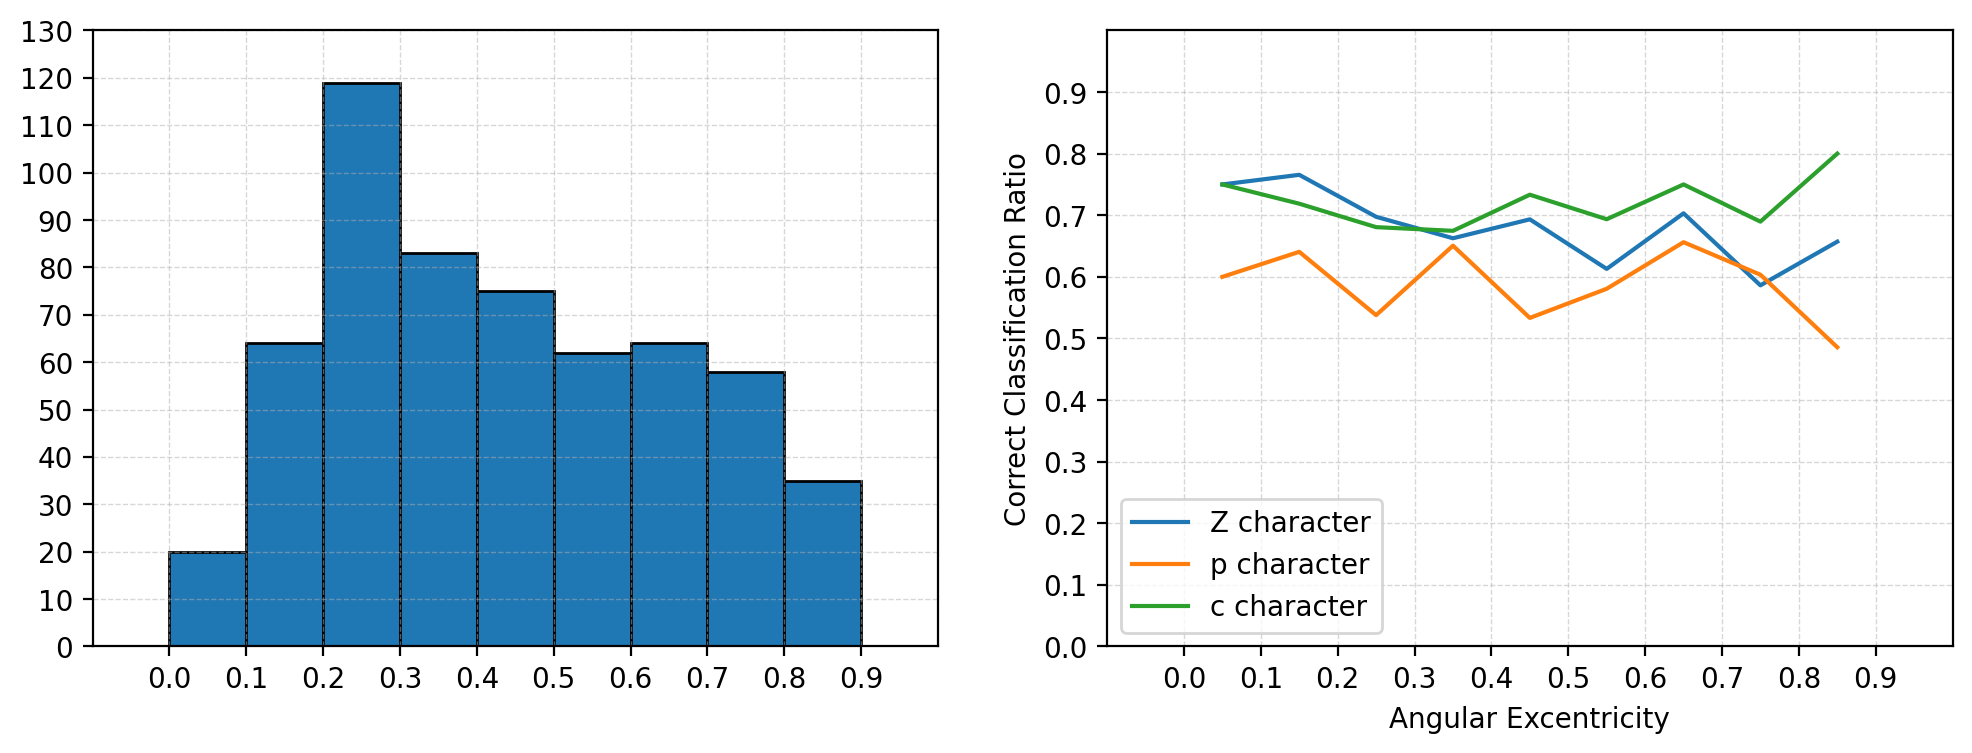

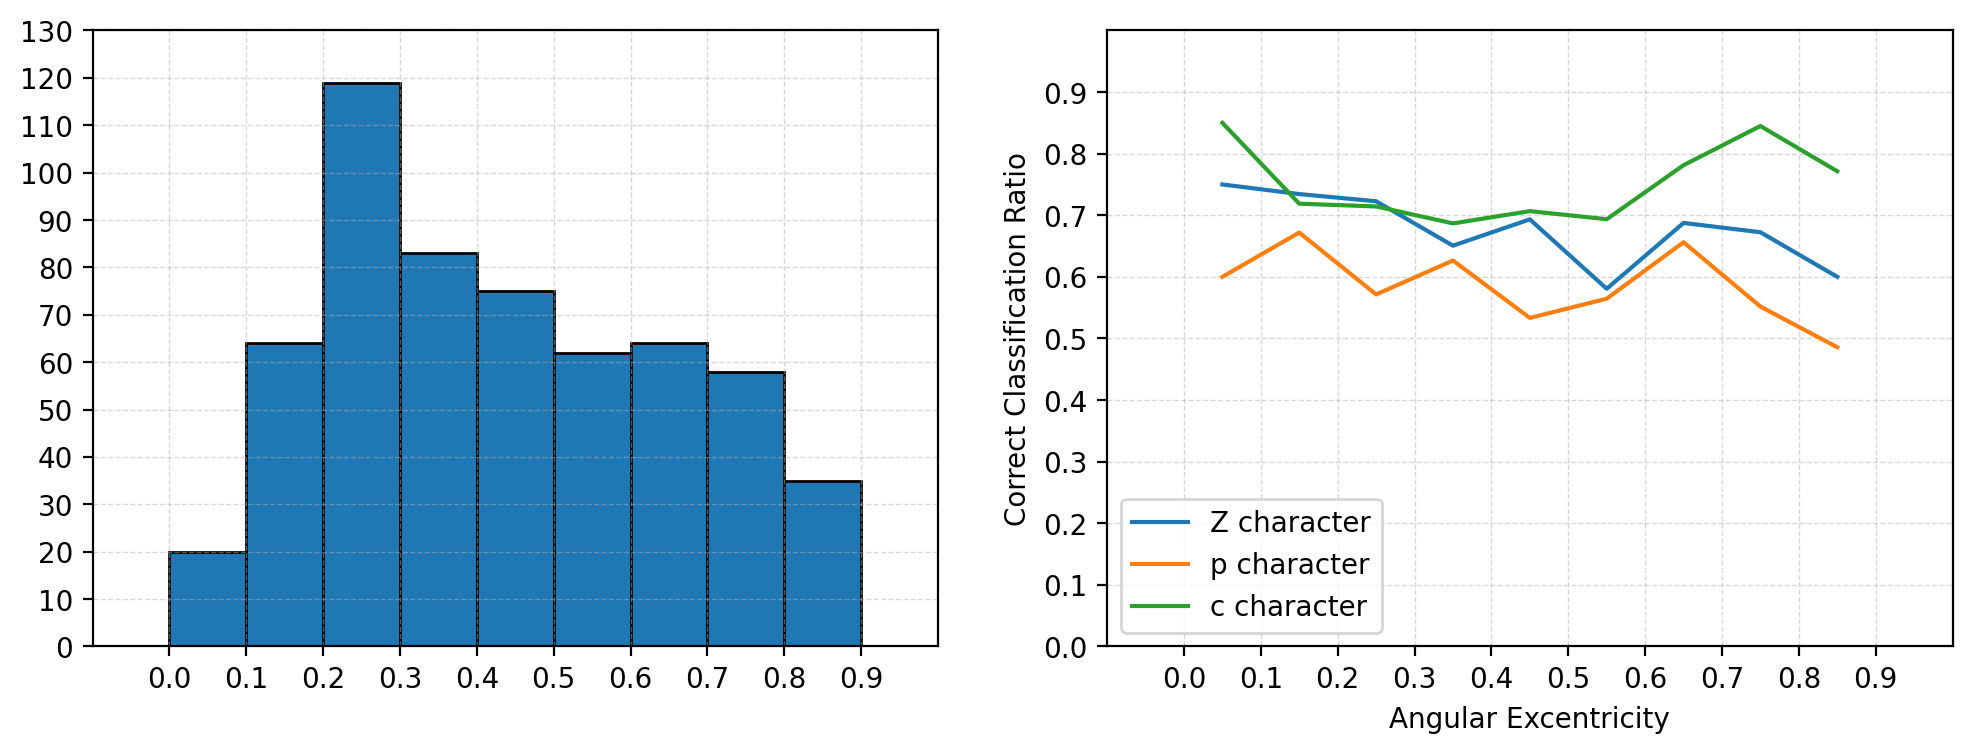

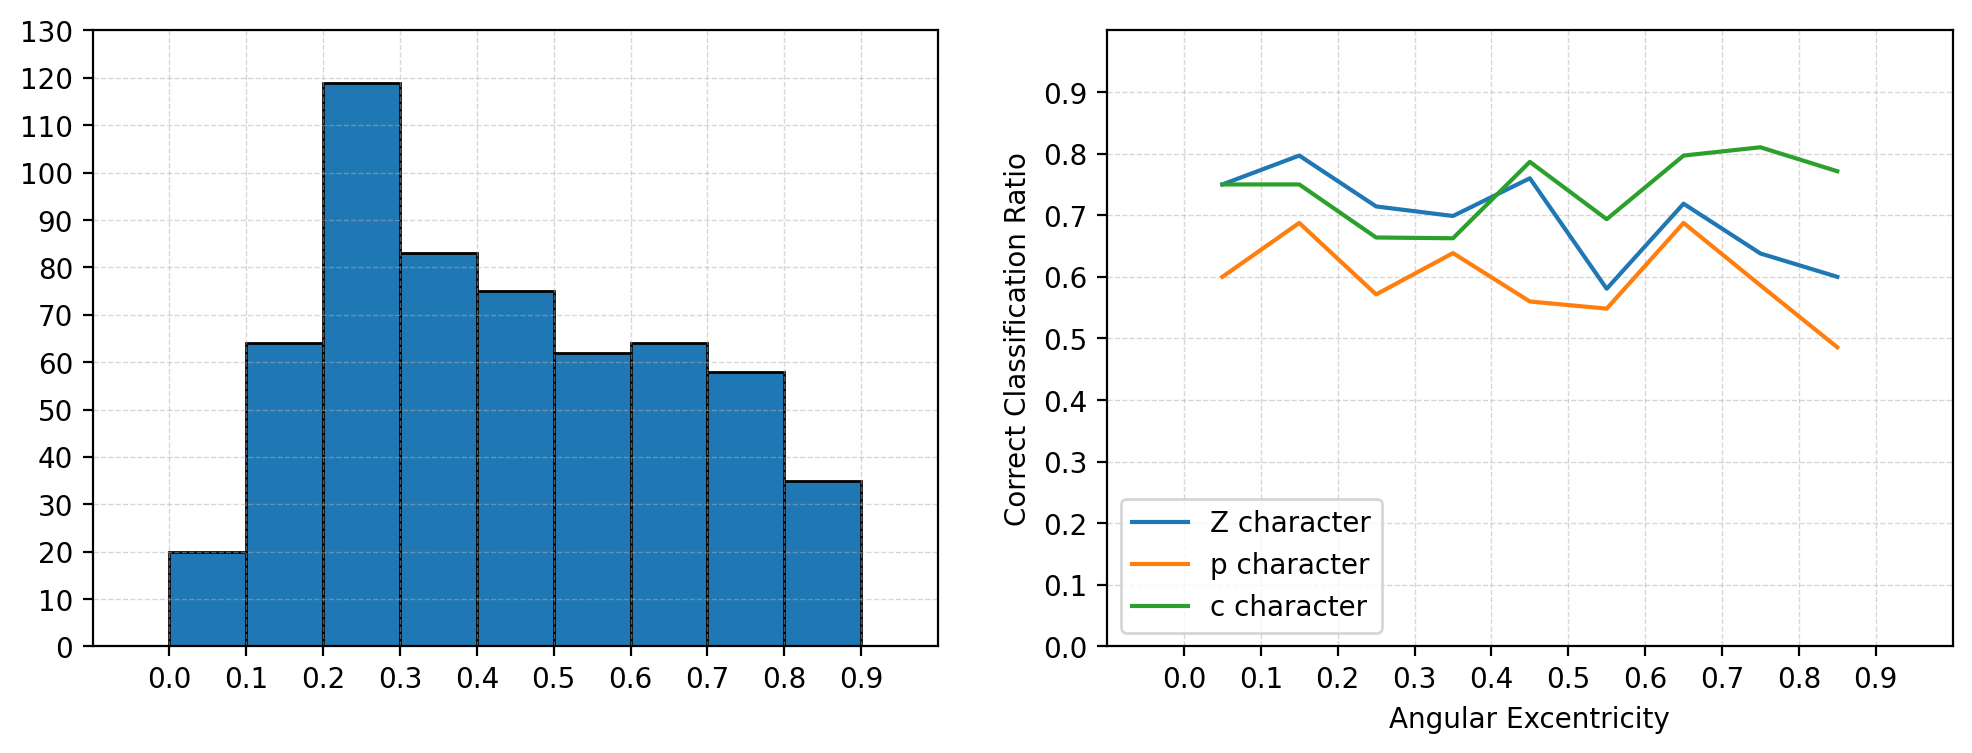

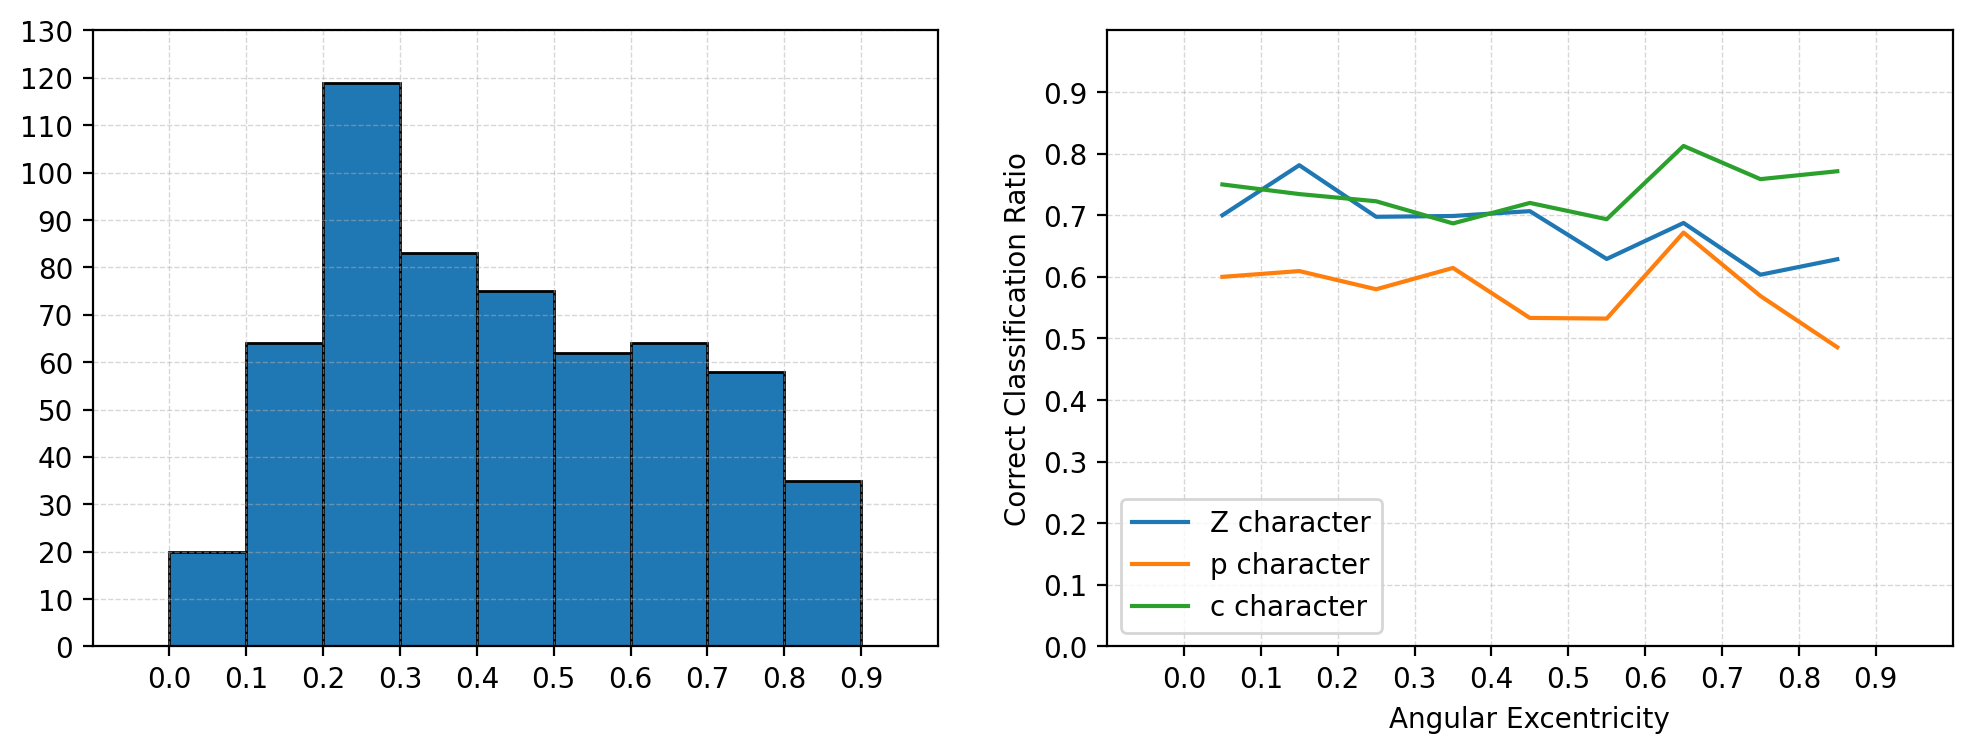

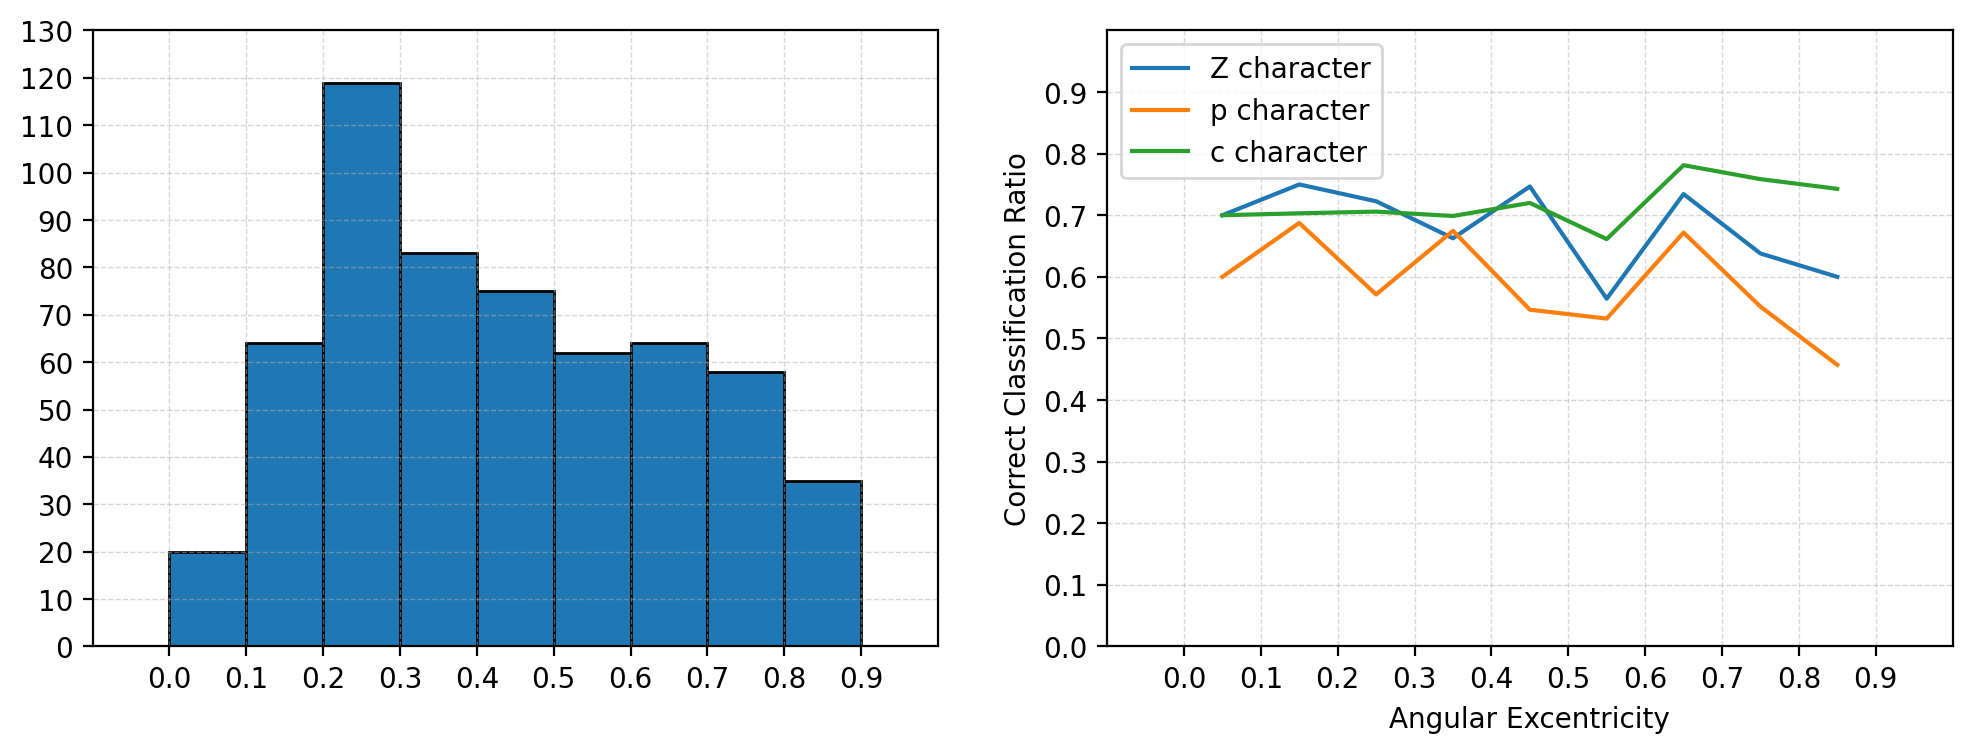

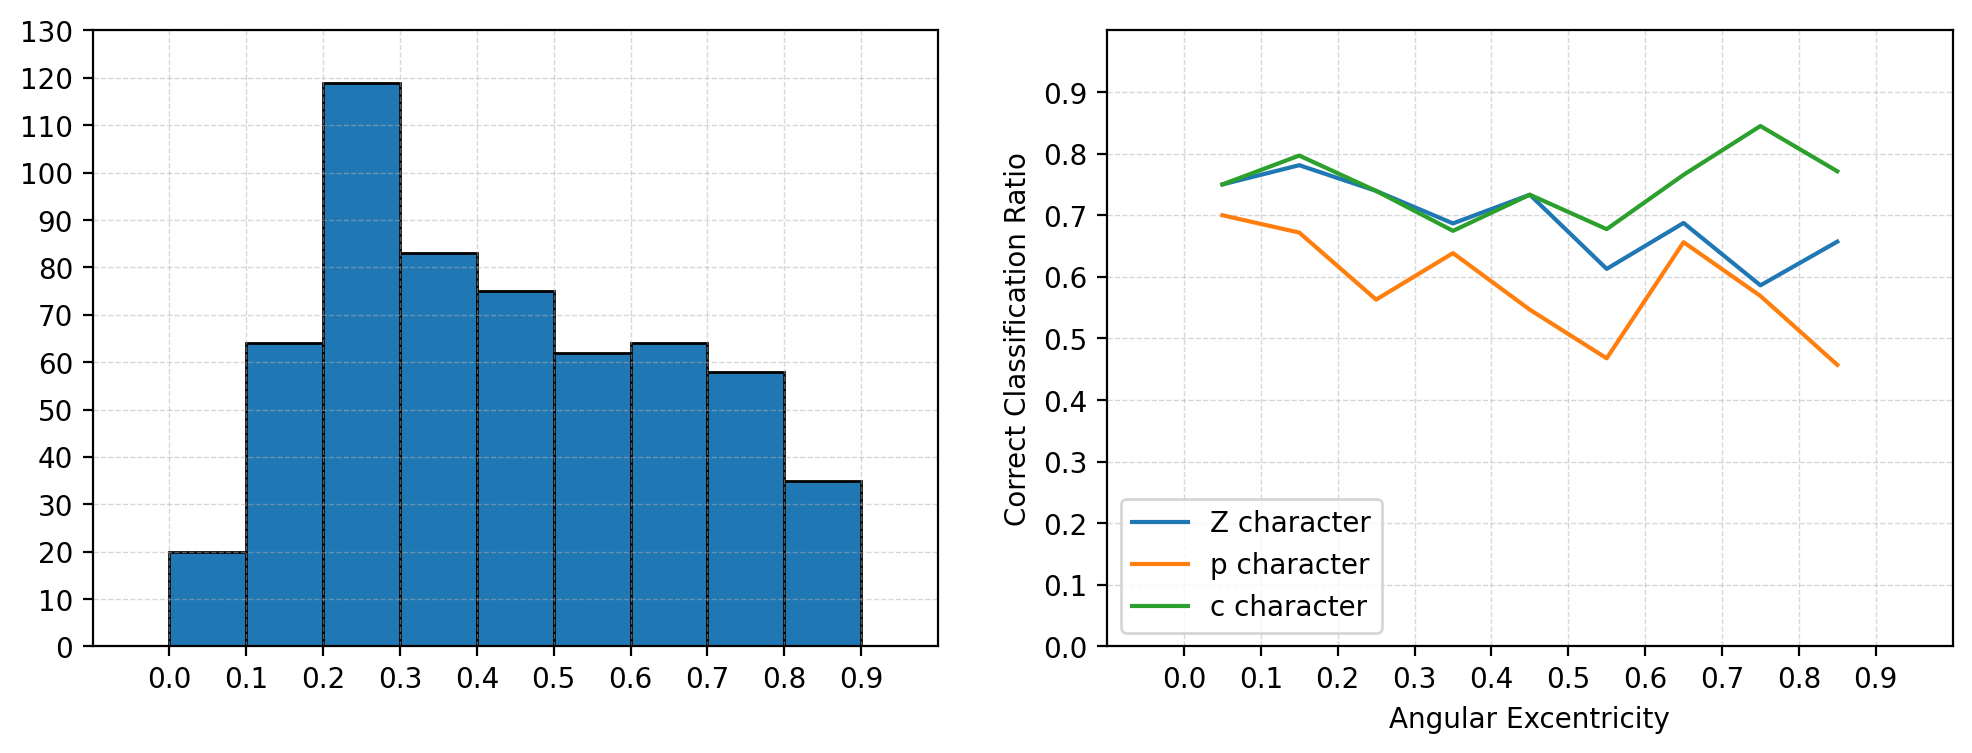

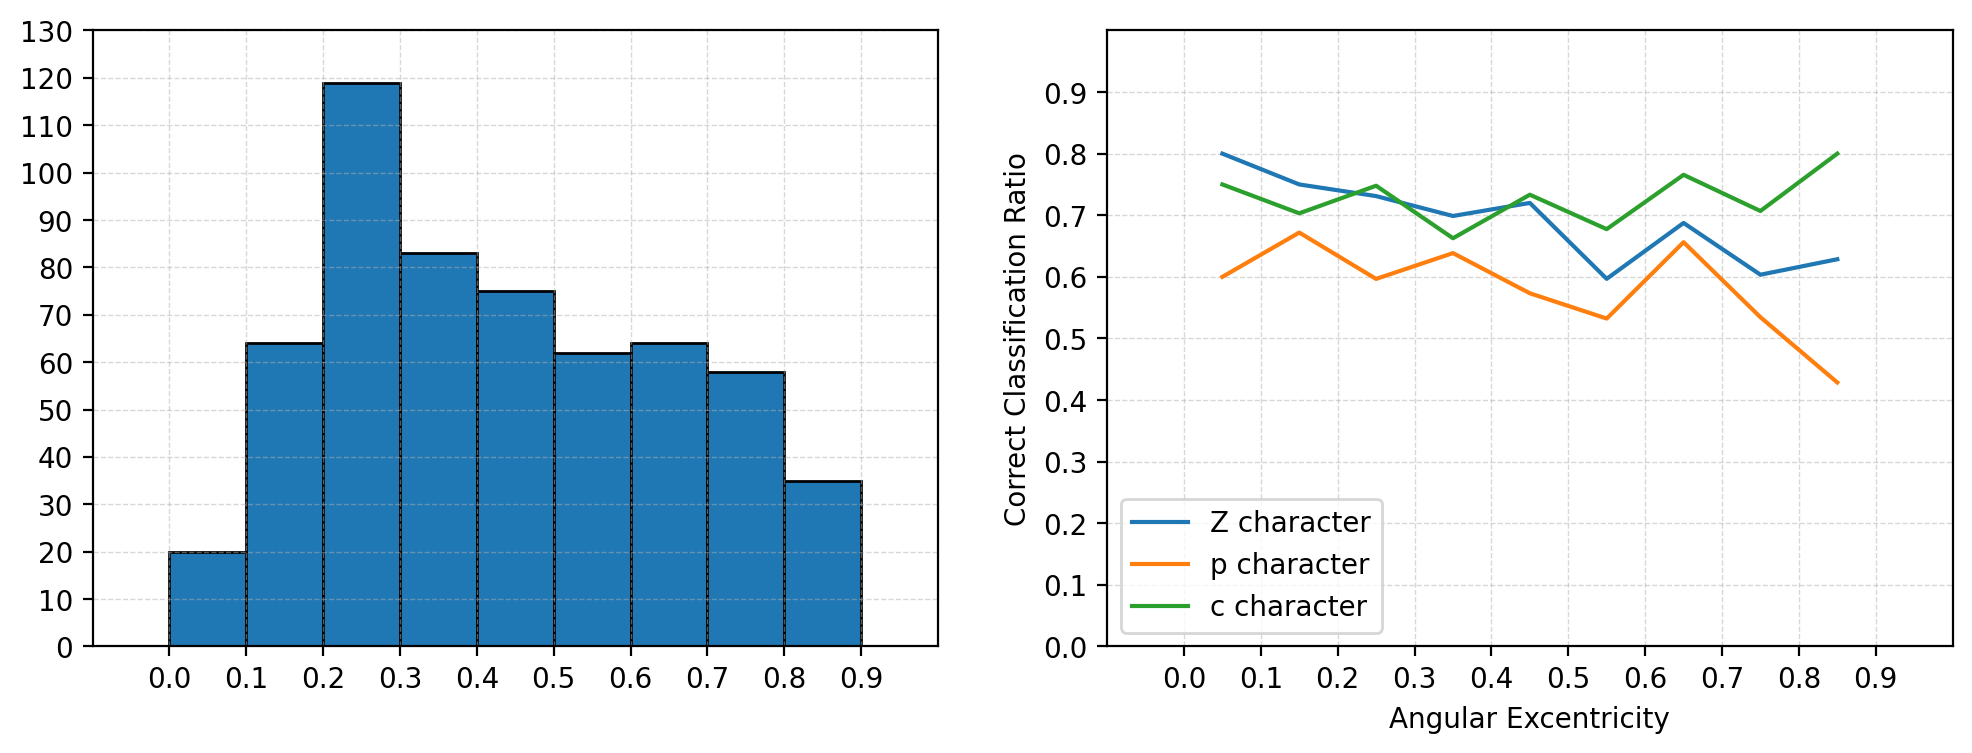

In [6]:
total_correct_c1_y1_pred = pd.DataFrame()
total_correct_c2_y2_pred = pd.DataFrame()
total_correct_c3_y3_pred = pd.DataFrame()

total_ratio_c1_y1_pred = pd.DataFrame()
total_ratio_c2_y2_pred = pd.DataFrame()
total_ratio_c3_y3_pred = pd.DataFrame()

for i, run_dir in enumerate(run_dirs):
    run_id = int(str(run_dir)[-2:])
    # get predictions of class 1
    yt_1 = pd.read_csv(run_dir / 'results' / 'y1.csv' )
    yt_1 = yt_1.loc[:, ~yt_1.columns.str.contains('^Unnamed')] 
    
    # get predictions of class 2
    yt_2 = pd.read_csv(run_dir / 'results' / 'y2.csv' )
    yt_2 = yt_2.loc[:, ~yt_2.columns.str.contains('^Unnamed')]

    # get predictions of class 3
    yt_3 = pd.read_csv(run_dir / 'results' / 'y3.csv' )
    yt_3 = yt_3.loc[:, ~yt_3.columns.str.contains('^Unnamed')]
    
    if i == 0:
        total_correct_c1_y1_pred["GT"] = yt_1[['y1_true']]
        total_correct_c2_y2_pred["GT"] = yt_2[['y2_true']]
        total_correct_c3_y3_pred["GT"] = yt_3[['y3_true']]


    # compute the ratio of correct prediction class 1
    correct_c1 = yt_1['y1_true'] == yt_1['y1_pred']
    correct_c1_ang = angular_excentricity[correct_c1]
    wrong_c1 = yt_1['y1_true'] != yt_1['y1_pred']
    wrong_c1_ang = angular_excentricity[wrong_c1]

    bins_c_c1 = np.histogram(correct_c1_ang.to_numpy(), bins=bins)[0]
    bins_w_c1 = np.histogram(wrong_c1_ang.to_numpy(), bins=bins)[0]

    ratio_c1 = bins_c_c1 / (bins_c_c1 + bins_w_c1)
    total_ratio_c1_y1_pred[f'run_{run_id}'] =  ratio_c1

    # compute the ratio of correct prediction class 2
    correct_c2 = yt_2['y2_true'] == yt_2['y2_pred']
    correct_c2_ang = angular_excentricity[correct_c2]
    wrong_c2 = yt_2['y2_true'] != yt_2['y2_pred']
    wrong_c2_ang = angular_excentricity[wrong_c2]

    bins_c_c2 = np.histogram(correct_c2_ang.to_numpy(), bins=bins)[0]
    bins_w_c2 = np.histogram(wrong_c2_ang.to_numpy(), bins=bins)[0]

    ratio_c2 = bins_c_c2 / (bins_c_c2 + bins_w_c2)
    total_ratio_c2_y2_pred[f'run_{run_id}'] =  ratio_c2

    # compute the ratio of correct prediction class 3
    correct_c3 = yt_3['y3_true'] == yt_3['y3_pred']
    correct_c3_ang = angular_excentricity[correct_c3]
    wrong_c3 = yt_3['y3_true'] != yt_3['y3_pred']
    wrong_c3_ang = angular_excentricity[wrong_c3]

    bins_c_c3 = np.histogram(correct_c3_ang.to_numpy(), bins=bins)[0]
    bins_w_c3 = np.histogram(wrong_c3_ang.to_numpy(), bins=bins)[0]

    ratio_c3 = bins_c_c3 / (bins_c_c3 + bins_w_c3)
    total_ratio_c3_y3_pred[f'run_{run_id}'] =  ratio_c3


    # print(correct_c1.shape)
    # print(correct_c1.head())
    # print(wrong_c1.shape)
    # print(wrong_c1.head())

    # f = plt.figure()
    # plt.hist(correct_c1_ang.to_numpy(), bins=bins, ec='black', label='Correct',stacked=True, alpha=0.5)
    # plt.hist(wrong_c1_ang.to_numpy(), bins=bins, ec='black', label='Correct',stacked=True, alpha=0.5)
    # plt.show

    f,a = plt.subplots(nrows=1,ncols=2,figsize=(6*2,4),dpi=200)
    b_x = np.array([(bins[i]+ bins[i+1])/2 for i in range(len(bins)-1)])
    n,_,_ =a[0].hist(angular_excentricity, bins=bins, ec='black', )
    a[0].set_xlim([-0.1,1])
    a[0].set_yticks(np.arange(0,np.max(n)+20,10))
    a[0].set_xticks(np.arange(0,1,.1))
    a[1].plot(b_x, ratio_c1, label='Z character')
    a[1].plot(b_x,ratio_c2, label='p character')
    a[1].plot(b_x,ratio_c3, label='c character')
    a[1].set_xlabel('Angular Excentricity')
    a[1].set_ylabel('Correct Classification Ratio')
    a[1].legend()
    a[1].set_ylim([0,1])
    a[1].set_xlim([-0.1,1])
    a[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    a[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
    a[1].set_yticks(np.arange(0,1,.1))
    a[1].set_xticks(np.arange(0,1,.1))
    # a[1].grid()
    f.show()


    # print(total_y1_pred.head())
    # print(total_y1_pred.shape)
    
    # break

# print(total_ratio_c1_y1_pred.head())
print(total_ratio_c1_y1_pred.shape)

# show the average ratio of correct prediction for each class
# total_ratio_c1_y1_pred["mean"] = total_ratio_c1_y1_pred.mean(axis=1)
# total_ratio_c2_y2_pred["mean"] = total_ratio_c2_y2_pred.mean(axis=1)
# total_ratio_c3_y3_pred["mean"] = total_ratio_c3_y3_pred.mean(axis=1)

# total_ratio_c1_y1_pred["std"] = total_ratio_c1_y1_pred.std(axis=1)
# total_ratio_c2_y2_pred["std"] = total_ratio_c2_y2_pred.std(axis=1)
# total_ratio_c3_y3_pred["std"] = total_ratio_c3_y3_pred.std(axis=1)

total_ratio_c1_y1_pred.info()



    

In [7]:
total_ratio_c1_y1_pred.transpose()

0         1         2         3         4         5         6  \
run_21  0.80  0.781250  0.714286  0.674699  0.706667  0.580645  0.703125   
run_22  0.75  0.765625  0.705882  0.614458  0.693333  0.580645  0.671875   
run_23  0.80  0.765625  0.739496  0.662651  0.706667  0.596774  0.687500   
run_24  0.75  0.781250  0.714286  0.710843  0.706667  0.596774  0.703125   
run_25  0.70  0.765625  0.689076  0.686747  0.733333  0.612903  0.734375   
run_26  0.75  0.750000  0.747899  0.650602  0.720000  0.629032  0.671875   
run_27  0.75  0.765625  0.714286  0.674699  0.706667  0.596774  0.687500   
run_28  0.80  0.796875  0.705882  0.626506  0.680000  0.612903  0.718750   
run_29  0.75  0.750000  0.714286  0.686747  0.720000  0.580645  0.718750   
run_30  0.75  0.750000  0.739496  0.698795  0.706667  0.564516  0.734375   
run_31  0.75  0.812500  0.722689  0.710843  0.693333  0.596774  0.718750   
run_32  0.75  0.781250  0.731092  0.698795  0.733333  0.580645  0.687500   
run_33  0.70  0.750000  0.697479  0.650602  0.706667  0.596774  0.687500   
run_34  0.75  0.765625  0.697479  0.662651  0.693333  0.612903  0.703125   
run_35  0.75  0.734375  0.722689  0.650602  0.693333  0.580645  0.687500   
run_36  0.75  0.796875  0.714286  0.698795  0.760000  0.580645  0.718750   
run_37  0.70  0.781250  0.697479  0.698795  0.706667  0.629032  0.687500   
run_38  0.70  0.750000  0.722689  0.662651  0.746667  0.564516  0.734375   
run_39  0.75  0.781250  0.739496  0.686747  0.733333  0.612903  0.687500   
run_40  0.80  0.750000  0.731092  0.698795  0.720000  0.596774  0.687500   

               7         8   9  
run_21  0.586207  0.628571 NaN  
run_22  0.637931  0.571429 NaN  
run_23  0.603448  0.628571 NaN  
run_24  0.603448  0.600000 NaN  
run_25  0.637931  0.657143 NaN  
run_26  0.637931  0.657143 NaN  
run_27  0.620690  0.685714 NaN  
run_28  0.603448  0.600000 NaN  
run_29  0.637931  0.628571 NaN  
run_30  0.620690  0.571429 NaN  
run_31  0.620690  0.628571 NaN  
run_32  0.568966  0.657143 NaN  
run_33  0.620690  0.685714 NaN  
run_34  0.586207  0.657143 NaN  
run_35  0.672414  0.600000 NaN  
run_36  0.637931  0.600000 NaN  
run_37  0.603448  0.628571 NaN  
run_38  0.637931  0.600000 NaN  
run_39  0.586207  0.657143 NaN  
run_40  0.603448  0.628571 NaN

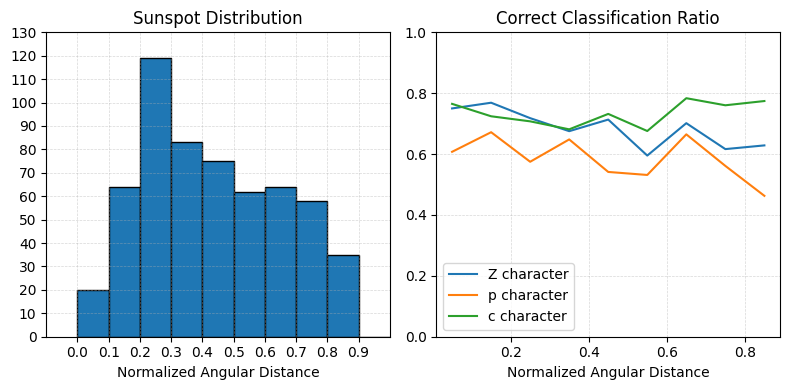

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

n,_,_ =ax[0].hist(angular_excentricity, bins=bins, ec='black', )
ax[0].set_xlim([-0.1,1])
ax[0].set_yticks(np.arange(0,np.max(n)+20,10))
ax[0].set_xticks(np.arange(0,1,.1))
ax[0].set_xlabel('Normalized Angular Distance')
# ax[0].set_ylabel('Count')
ax[0].set_ylabel('')
ax[0].set_title('Sunspot Distribution')
ax[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)

#code for Z character
df = total_ratio_c1_y1_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='Z character',
                ax=ax[1]
            )
# code for p character
df = total_ratio_c2_y2_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='p character',
                ax=ax[1]
            )
# code for c character
df = total_ratio_c3_y3_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(

                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='c character',
                ax=ax[1]
            )
        
ax[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_ylim([0,1])
ax[1].set_xlabel('Normalized Angular Distance')
# ax[1].set_ylabel('Correct Classification Ratio')
ax[1].set_ylabel('')
ax[1].set_title('Correct Classification Ratio')

ax[1].legend(loc='lower left')
        
fig.tight_layout()
plt.savefig("Hist&Accuracy.pdf", format="pdf", bbox_inches="tight")

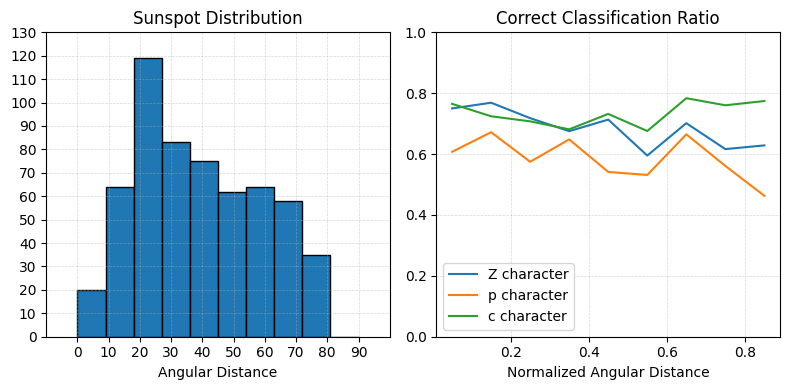

In [9]:
n_bins = 11
bins = np.linspace(0, 90, n_bins, endpoint=True)

angular_excentricity = pd.read_csv(run_dirs[0] / 'results' / 'angular_excentricity.csv' )*90
angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

n,_,_ =ax[0].hist(angular_excentricity, bins=bins, ec='black', )
ax[0].set_xlim([-10,100])
ax[0].set_yticks(np.arange(0,np.max(n)+20,10))
ax[0].set_xticks(np.arange(0,100,10))
ax[0].set_xlabel('Angular Distance')
# ax[0].set_ylabel('Count')
ax[0].set_ylabel('')
ax[0].set_title('Sunspot Distribution')
ax[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)

#code for Z character
df = total_ratio_c1_y1_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='Z character',
                ax=ax[1]
            )
# code for p character
df = total_ratio_c2_y2_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='p character',
                ax=ax[1]
            )
# code for c character
df = total_ratio_c3_y3_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(

                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='c character',
                ax=ax[1]
            )
        
ax[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_ylim([0,1])
ax[1].set_xlabel('Normalized Angular Distance')
# ax[1].set_ylabel('Correct Classification Ratio')
ax[1].set_ylabel('')
ax[1].set_title('Correct Classification Ratio')

ax[1].legend(loc='lower left')
        
fig.tight_layout()
plt.savefig("Hist&Accuracy.pdf", format="pdf", bbox_inches="tight")

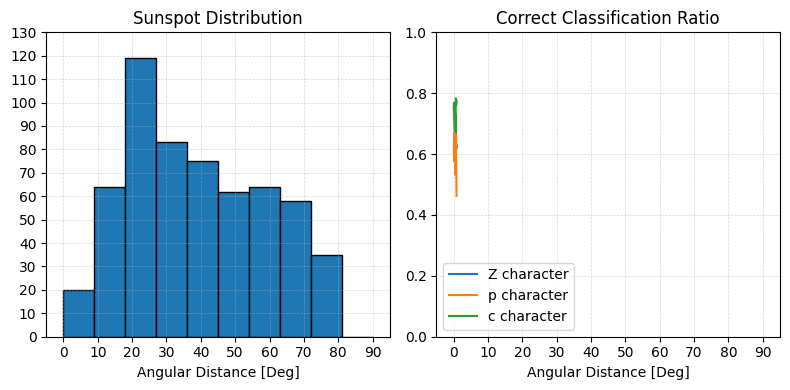

In [10]:
n_bins = 11
bins = np.linspace(0, 90, n_bins, endpoint=True)

angular_excentricity = pd.read_csv(run_dirs[0] / 'results' / 'angular_excentricity.csv' )*90
angular_excentricity = angular_excentricity.iloc[:, ~angular_excentricity.columns.str.contains('^Unnamed')] 


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

n,_,_ =ax[0].hist(angular_excentricity, bins=bins, ec='black', )
ax[0].set_xlim([-5,95])
ax[0].set_yticks(np.arange(0,np.max(n)+20,10))
ax[0].set_xticks(np.arange(0,100,10))
ax[0].set_xlabel('Angular Distance [Deg]')
# ax[0].set_ylabel('Count')
ax[0].set_ylabel('')
ax[0].set_title('Sunspot Distribution')
ax[0].grid(linestyle='--', linewidth=0.5, alpha=0.5)

#code for Z character
df = total_ratio_c1_y1_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='Z character',
                ax=ax[1]
            )
# code for p character
df = total_ratio_c2_y2_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(
                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='p character',
                ax=ax[1]
            )
# code for c character
df = total_ratio_c3_y3_pred.transpose()
col_dict = dict(zip(df.columns, b_x))
df = df.rename(columns=col_dict)
melted_df = pd.melt(df, var_name='Bin', value_name='Accuracy')
bin_means = melted_df.groupby('Bin').mean().reset_index()
g = sns.lineplot(

                data=bin_means,
                x="Bin",
                y='Accuracy',
                label='c character',
                ax=ax[1]
            )
        
ax[1].grid(linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_ylim([0,1])
ax[1].set_xlim([-5,95])
ax[1].set_xticks(range(0,90+10,10))
ax[1].set_xlabel('Angular Distance [Deg]')
# ax[1].set_ylabel('Correct Classification Ratio')
ax[1].set_ylabel('')
ax[1].set_title('Correct Classification Ratio')

ax[1].legend(loc='lower left')
        
fig.tight_layout()
plt.savefig("Hist&Accuracy.pdf", format="pdf", bbox_inches="tight")

# Majority vote

In [11]:
print(mapper)
print(inverted_mapper)

{'used_c1': {'A': 0, 'B': 1, 'C': 2, 'SuperGroup': 3, 'H': 4}, 'used_c2': {'x': 0, 'r': 1, 'sym': 2, 'asym': 3}, 'used_c3': {'x': 0, 'o': 1, 'frag': 2}}
{'inv_c1': {'0': 'A', '1': 'B', '2': 'C', '3': 'SuperGroup', '4': 'H'}, 'inv_c2': {'0': 'x', '1': 'r', '2': 'sym', '3': 'asym'}, 'inv_c3': {'0': 'x', '1': 'o', '2': 'frag'}}


In [12]:
# code for y1
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y1_pred = total_y1_pred[['GT', 'pred']]


############################################################################################################
#code for y2
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y2_pred = total_y2_pred[['GT', 'pred']]

############################################################################################################
#code for y3
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y3_pred = total_y3_pred[['GT', 'pred']]

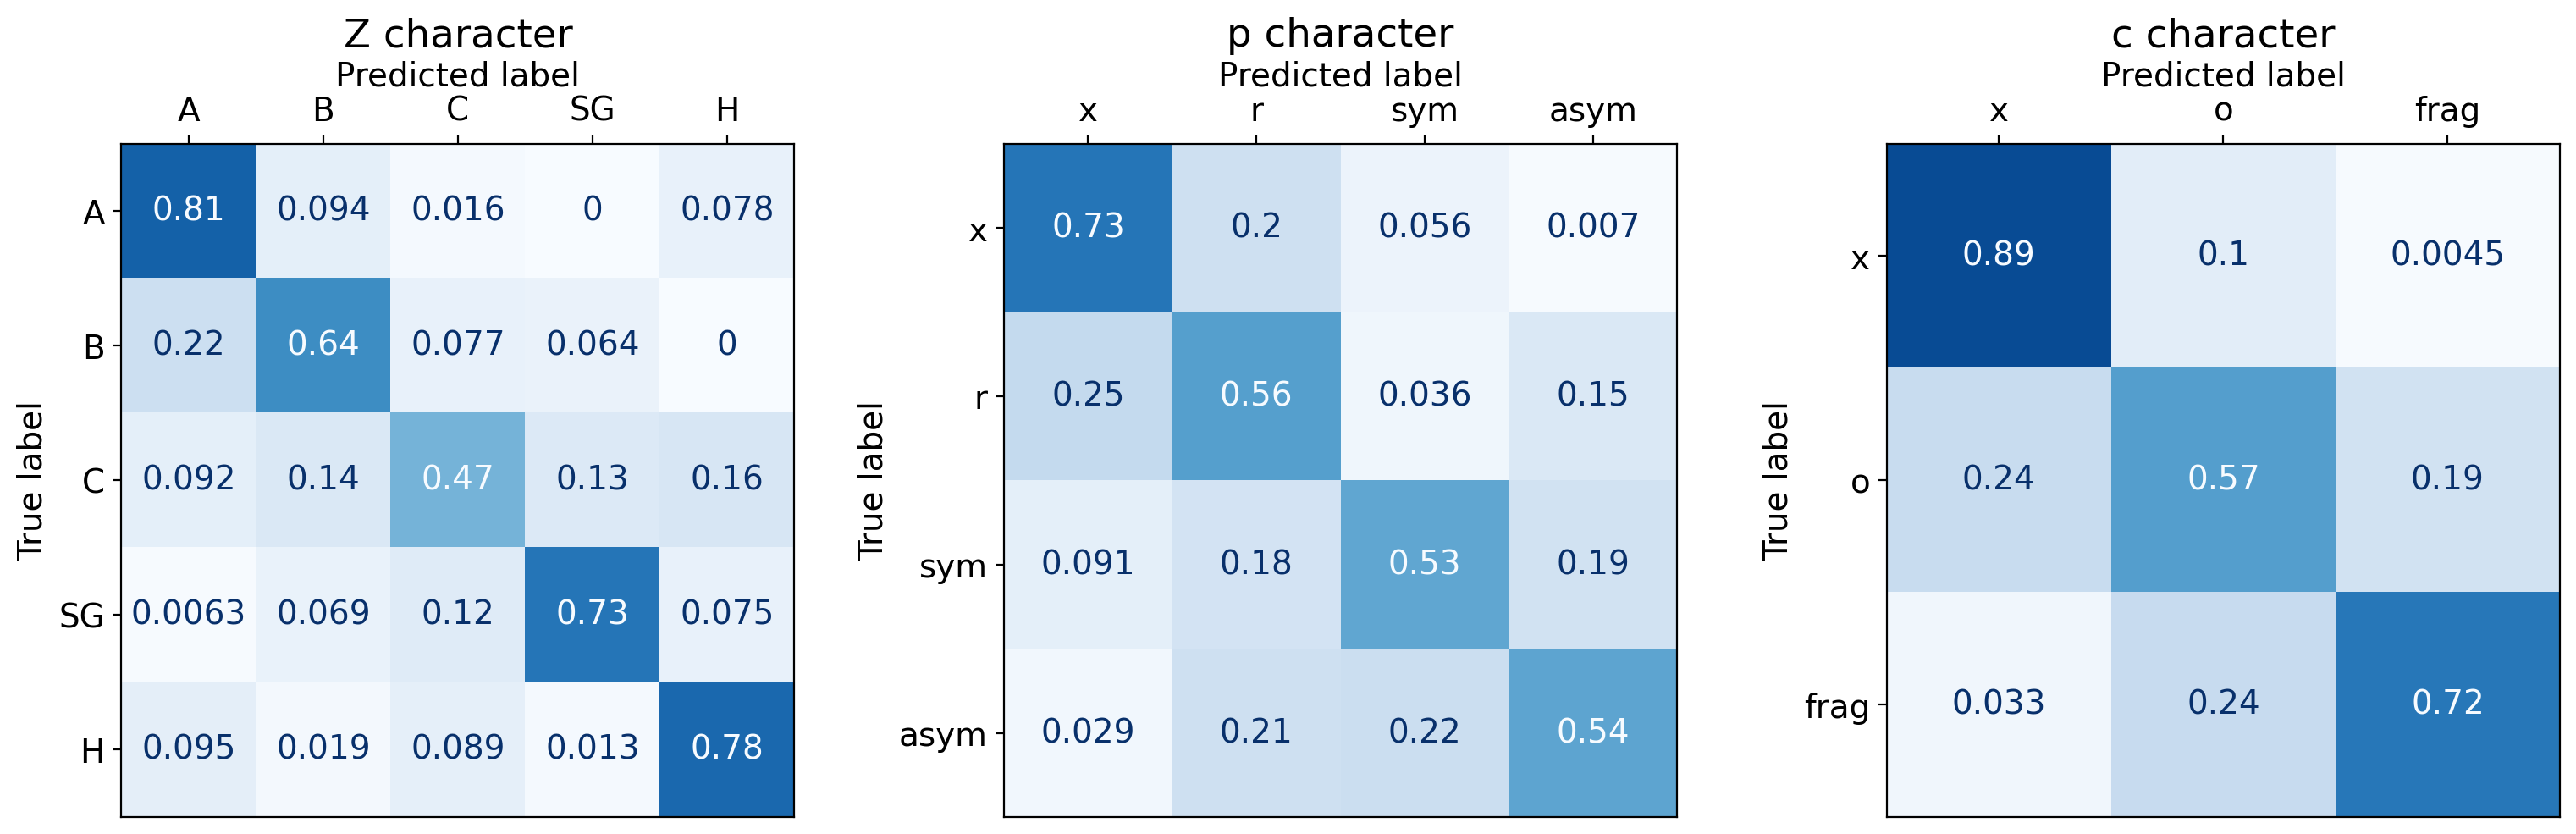

In [13]:
#code for y1
used_c1 = mapper["used_c1"]
if 'SuperGroup' in used_c1.keys():
    used_c1["SG"] = used_c1.pop("SuperGroup")
    used_c1["H"] = used_c1.pop("H")
    
c1_names  = list(used_c1.keys())
y1_true = federated_y1_pred['GT'].values
y1_pred = federated_y1_pred['pred'].values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = federated_y2_pred['GT'].values
y2_pred = federated_y2_pred['pred'].values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = federated_y3_pred['GT'].values
y3_pred = federated_y3_pred['pred'].values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)



plt.rcParams.update({'font.size': 14})

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)
# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z character')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p character')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c character')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
fig.show()

plt.savefig("VoteGlobal.pdf", format="pdf", bbox_inches="tight")

Associated F1, precision, recall  scores ?

In [14]:
"""
Code to parse sklearn classification_report
Original: https://gist.github.com/julienr/6b9b9a03bd8224db7b4f
Modified to work with Python 3 and classification report averages
"""

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))
    lines=[s for s in lines if 'accuracy' not in s]
    
    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

def print_to_file(string, filename):
    with open(filename, 'w') as f:
        f.write(string)

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

methods = ['micro', 'weighted']
for method in methods:
    print(f'##########.  {method}')

    z_f1 = f1_score(y1_true,y1_pred, average=method)
    p_f1 = f1_score(y2_true,y2_pred, average=method)
    c_f1 = f1_score(y3_true,y3_pred, average=method)

    print(f'F1 score for Z: {z_f1}')
    print(f'F1 score for p: {p_f1}')
    print(f'F1 score for c: {c_f1}')
    print()

    z_prec = precision_score(y1_true,y1_pred, average=method)
    p_prec = precision_score(y2_true,y2_pred, average=method)
    c_prec = precision_score(y3_true,y3_pred, average=method)

    print(f'precision score for Z: {z_prec}')
    print(f'precision score for p: {p_prec}')
    print(f'precision score for c: {c_prec}')
    print()

    z_recall = recall_score(y1_true,y1_pred, average=method)
    p_recall = recall_score(y2_true,y2_pred, average=method)
    c_recall = recall_score(y3_true,y3_pred, average=method)

    print(f'recall score for Z: {z_recall}')
    print(f'recall score for p: {p_recall}')
    print(f'recall score for c: {c_recall}')
    print()

##########.  micro
F1 score for Z: 0.6896551724137931
F1 score for p: 0.5879310344827586
F1 score for c: 0.7258620689655172

precision score for Z: 0.6896551724137931
precision score for p: 0.5879310344827586
precision score for c: 0.7258620689655172

recall score for Z: 0.6896551724137931
recall score for p: 0.5879310344827586
recall score for c: 0.7258620689655172

##########.  weighted
F1 score for Z: 0.6895419443332218
F1 score for p: 0.6064699376440057
F1 score for c: 0.7194002953058906

precision score for Z: 0.7003000043196115
precision score for p: 0.6490952922170755
precision score for c: 0.7238908686849628

recall score for Z: 0.6896551724137931
recall score for p: 0.5879310344827586
recall score for c: 0.7258620689655172



In [16]:
from sklearn.metrics import precision_recall_fscore_support as score


y1_true = federated_y1_pred['GT'].values
print(y1_true.shape)
y1_pred = federated_y1_pred['pred'].values
print(y1_true.shape)

precision, recall, fscore, support = score(y1_true, y1_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

(580,)
(580,)
precision: [0.54166667 0.57471264 0.58762887 0.83571429 0.775     ]
recall: [0.8125     0.64102564 0.475      0.73125    0.78481013]
fscore: [0.65       0.60606061 0.52534562 0.78       0.77987421]
support: [ 64  78 120 160 158]


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y1_true, y1_pred))

print_to_file(metrics.classification_report(y1_true, y1_pred),'./tmp.txt')
with open('./tmp.txt','r') as f:
    data = parse_classification_report(f.read())
    print(report_to_latex_table(data))
# data = parse_classification_report(f'{metrics.classification_report(y1_true, y1_pred)}')
# print(report_to_latex_table(data))
# metrics.classification_report(y1_true, y1_pred)

In [ ]:
from sklearn import metrics

y2_true = federated_y2_pred['GT'].values
print(y1_true.shape)
y2_pred = federated_y2_pred['pred'].values
print(y1_true.shape)

print(metrics.classification_report(y2_true, y2_pred))

print_to_file(metrics.classification_report(y2_true, y2_pred),'./tmp.txt')
with open('./tmp.txt','r') as f:
    data = parse_classification_report(f.read())
    print(report_to_latex_table(data))

In [ ]:
from sklearn import metrics

y3_true = federated_y3_pred['GT'].values
print(y1_true.shape)
y3_pred = federated_y3_pred['pred'].values
print(y1_true.shape)

print_to_file(metrics.classification_report(y3_true, y3_pred),'./tmp.txt')
with open('./tmp.txt','r') as f:
    data = parse_classification_report(f.read())
    print(report_to_latex_table(data))

# Aggregation

On prend toutes les prédictions comme venant d'un seul modèle -> les 20 prédictions pour un seul samplesont considérées comme 20 samples différents -> on concatène toutes les prédictions. 

In [ ]:
total_y1_pred.head()

In [17]:
agg_y1_gt = pd.concat([total_y1_pred['GT'].astype(int)]*len(run_dirs))
agg_y1_pred = pd.concat([total_y1_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y1_gt.shape)
print(agg_y1_gt.head())
print(agg_y1_pred.shape)
print(agg_y1_pred.head())

agg_y2_gt = pd.concat([total_y2_pred['GT'].astype(int)]*len(run_dirs))
agg_y2_pred = pd.concat([total_y2_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y2_gt.shape)
print(agg_y2_pred.shape)

agg_y3_gt = pd.concat([total_y3_pred['GT'].astype(int)]*len(run_dirs))
agg_y3_pred = pd.concat([total_y3_pred[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

print(agg_y3_gt.shape)
print(agg_y3_pred.shape)

(11600,)
0    0
1    3
2    0
3    0
4    1
Name: GT, dtype: int64
(11600,)
0    1
1    3
2    4
3    1
4    1
dtype: int64
(11600,)
(11600,)
(11600,)
(11600,)


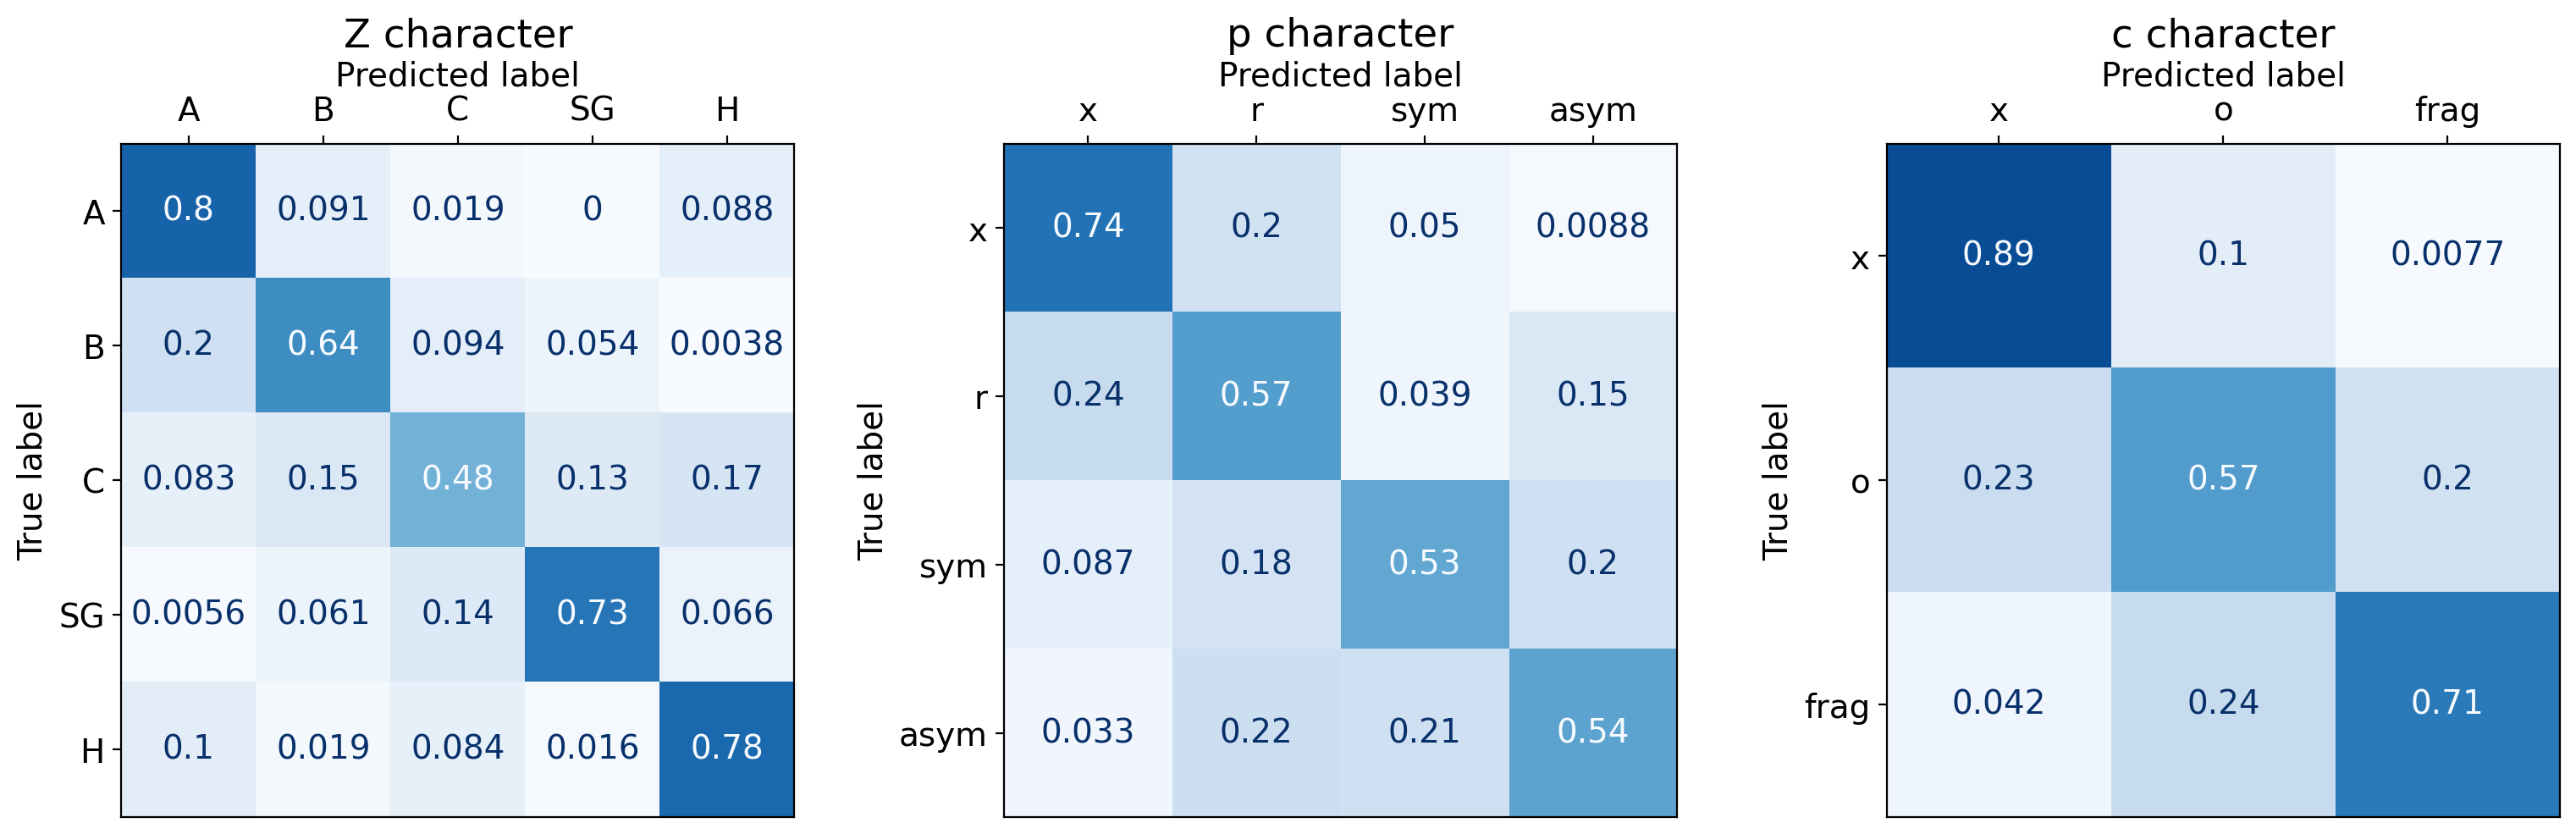

In [18]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = agg_y1_gt.values
y1_pred = agg_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = agg_y2_gt.values
y2_pred = agg_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = agg_y3_gt.values
y3_pred = agg_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z character')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p character')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c character')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
fig.show()
plt.savefig("VoteAggregation.pdf", format="pdf", bbox_inches="tight")


# Erreurs V2
Filtrer pour ne conserver que les entrées telles que le majority vote était FAUX


In [19]:
# code for y1
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y1_pred['pred'] = total_y1_pred.iloc[:, 1:].mode(axis=1)[0]
total_y1_pred['pred'] = total_y1_pred['pred'].astype(int)
total_y1_pred['GT'] = total_y1_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y1_pred = total_y1_pred[['GT', 'pred']]


############################################################################################################
#code for y2
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y2_pred['pred'] = total_y2_pred.iloc[:, 1:].mode(axis=1)[0]
total_y2_pred['pred'] = total_y2_pred['pred'].astype(int)
total_y2_pred['GT'] = total_y2_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y2_pred = total_y2_pred[['GT', 'pred']]

############################################################################################################
#code for y3
# for each row, get the most frequent prediction withouth the GT column and put it in a new column
total_y3_pred['pred'] = total_y3_pred.iloc[:, 1:].mode(axis=1)[0]
total_y3_pred['pred'] = total_y3_pred['pred'].astype(int)
total_y3_pred['GT'] = total_y3_pred['GT'].astype(int)

# create new dataframe with the GT and the pred
federated_y3_pred = total_y3_pred[['GT', 'pred']]

In [20]:
print(federated_y1_pred.shape)
err_federated_y1_pred = federated_y1_pred['GT'] != federated_y1_pred['pred']
# get the corresponding rows in total_y1_pred
y1_fed_errors = total_y1_pred[err_federated_y1_pred]

err_federated_y2_pred = federated_y2_pred['GT'] != federated_y2_pred['pred']
# get the corresponding rows in total_y2_pred
y2_fed_errors = total_y2_pred[err_federated_y2_pred]

err_federated_y3_pred = federated_y3_pred['GT'] != federated_y3_pred['pred']
# get the corresponding rows in total_y3_pred
y3_fed_errors = total_y3_pred[err_federated_y3_pred]

print(y1_fed_errors.shape)
print(y2_fed_errors.shape)
print(y3_fed_errors.shape)

(580, 2)
(180, 22)
(239, 22)
(159, 22)


Now, aggregate Errors

In [ ]:
agg_fed_y1_gt = pd.concat([y1_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y1_pred = pd.concat([y1_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

agg_fed_y2_gt = pd.concat([y2_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y2_pred = pd.concat([y2_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

agg_fed_y3_gt = pd.concat([y3_fed_errors['GT'].astype(int)]*len(run_dirs))
agg_fed_y3_pred = pd.concat([y3_fed_errors[f'run_{id}'].astype(int) for id in run_ids ], axis=0)


In [ ]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = agg_fed_y1_gt.values
y1_pred = agg_fed_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = agg_fed_y2_gt.values
y2_pred = agg_fed_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = agg_fed_y3_gt.values
y3_pred = agg_fed_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)

# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z character')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p character')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c character')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
fig.show()

plt.savefig("VoteErrors.pdf", format="pdf", bbox_inches="tight")

#### Failure cases

In [ ]:
logger = {"_target_": "pytorch_lightning.loggers.CSVLogger",
            "save_dir": 'csv_metrics'
}
config, model, dm, trainer = load_from_dir2(
                                    run_path= run_dirs[0],
                                    load_trainer=False,
                                    override = [
                                        f'~callbacks.wandb',

#                                         "+callbacks.failurecases={}",
#                                         f"+callbacks.failurecases._target_={failureCallback['_target_']}",
#                                         f"+callbacks.failurecases.focusMcIntoshChar={failureCallback['focusMcIntoshChar']}",
#                                         f"+callbacks.failurecases.focusGTCharClass={failureCallback['focusGTCharClass']}",
#                                         f"+callbacks.failurecases.focusPredCharClass={failureCallback['focusPredCharClass']}",
#                                         f"+callbacks.failurecases.should_norm={failureCallback['should_norm']}",

#                                         'module._target_="bioblue.module.McIntoshClassifier_SuperclassesOLD"',
#                                         'model._target_="bioblue.model.McIntoshClassifierOLD"',

                                        # f'model.input_format="{convert_to_new["input_format"]}"',
                                        # f"+model.input_format.visual={convert_to_new['input_format']['visual']}",
                                        # f"+model.input_format.numeric={convert_to_new['input_format']['numeric']}",

                                        # "+callbacks.explainCallback={}",
                                        # f'+callbacks.explainCallback._target_={explainCallback["_target_"]}',

                                        #remove wandb logger info
                                        f"~logger.0.project",
                                        f"~logger.0.name",
                                        f"~logger.0.resume",
                                        #replace with csv_logger
                                        f"logger.0._target_={logger['_target_']}",
                                        f"++logger.0.save_dir={logger['save_dir']}",

#                                         '~callbacks.wandb',
                                        # f'callbacks.Save_prediction.output_dir={str(run_dir/"predictions")}'
                                        
                                        f"++callbacks.ConfusionMatrix.output_dir={str(run_dir/'results')}",
                                    ]
                                )

In [ ]:
dm.setup()

In [ ]:
#get the test dataloader
test_dl = dm.test_dataloader()

In [ ]:
bs = config.dataset.batch_size
bs

In [ ]:
import matplotlib

for batch_idx, batch in enumerate(test_dl):
    print(batch_idx)
    img_indexes = (batch_idx * bs) + np.array(range(batch['image'].shape[0]))
    print(img_indexes)
    
    # print(batch.keys())
    # print(batch['image'].shape)

    # print(batch['class1'])

    # print(total_y1_pred['GT'][img_indexes])
    # print(total_y1_pred['pred'][img_indexes])

    cur_gt_1 = total_y1_pred['GT'][img_indexes]
    cur_pred_1 = total_y1_pred['pred'][img_indexes]
    cur_runPreds_1 = total_y1_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    cur_gt_2 = total_y2_pred['GT'][img_indexes]
    cur_pred_2 = total_y2_pred['pred'][img_indexes]
    cur_runPreds_2 = total_y2_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    cur_gt_3 = total_y3_pred['GT'][img_indexes]
    cur_pred_3 = total_y3_pred['pred'][img_indexes]
    cur_runPreds_2 = total_y3_pred[[f'run_{id}' for id in run_ids]].iloc[img_indexes]
    
    c1,c2,c3 = batch['class1'], batch['class2'], batch['class3']
    gt = {'class1':c1.squeeze(1),'class2':c2.squeeze(1),'class3':c3.squeeze(1)}


    pred =  {'class1':cur_pred_1.values,'class2':cur_pred_2.values,'class3':cur_pred_3.values}

#     incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
    incorrect_idx = np.where(cur_gt_1 != cur_pred_1)[0]
#     print(incorrect_idx)
    
    
#     for j in enumerate(incorrect_idx):
    for j in incorrect_idx:
        # show the batch['image'] at indexes where the GT and pred are different
        img = batch['image'][j]
        img = torch.flip(img,[0,1])
#         print(img.shape)
#         images_to_show = batch['image'][incorrect_idx]

        g_C1 = str(int(gt['class1'][j].cpu().numpy()))
        g_C1 = inverted_mapper['inv_c1'][g_C1]
        g_C1 = 'SG' if g_C1 == 'SuperGroup' else g_C1
        g_C2 = str(int(gt['class2'][j].cpu().numpy()))
        g_C2 = inverted_mapper['inv_c2'][g_C2]
        g_C3 = str(int(gt['class3'][j].cpu().numpy()))
        g_C3 = inverted_mapper['inv_c3'][g_C3]

        pred_C1 = str(pred['class1'][j])
        pred_C1 = inverted_mapper['inv_c1'][pred_C1] 
        pred_C1 = 'SG' if pred_C1 == 'SuperGroup' else pred_C1
        pred_C2 = str(pred['class2'][j])
        pred_C2 = inverted_mapper['inv_c2'][pred_C2] 
        pred_C3 = str(pred['class3'][j])
        pred_C3 = inverted_mapper['inv_c3'][pred_C3]
        
        strMcIntosh = f'{g_C1}_{g_C2}_{g_C3}'
        strMcIntosh_hat = f'{pred_C1}_{pred_C2}_{pred_C3}'
#         print(f"GT: {strMcIntosh}\nPred:{strMcIntosh_hat}")
        
        # title = f"GT: {inverted_mapper['inv_c1'][str(cur_gt[incorrect_idx[j]])]}\n Pred: {inverted_mapper['inv_c1'][str(cur_pred[incorrect_idx[j]])]}"
        
        normalize = matplotlib.colors.Normalize(vmin=0, vmax=4000)
        
        f = plt.figure(figsize=(8,4))
        a = f.add_subplot(121)
        a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
        a.set_title(f"{batch['group_name'][j]}")
        a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
        a.set_xticks([])
        a.set_yticks([])
        
        b = f.add_subplot(122)
        sns.countplot(x=cur_runPreds_1.iloc[j], ax=b, order=range(0, len(used_c1)))
        b.set_ylabel('')
        b.set_xlabel('')
        b.set_xticks(range(0, len(used_c1)))
#         b.set_xticklabels(list(used_c1.keys()), rotation=90)
        b.set_xticklabels(list(used_c1.keys()))
        b.set_yticklabels(range(0,len(run_dirs)+1,2))
        b.set_ylim([0, len(run_dirs)+1])
#         b.set_title(f'Confusion Histogram for sample')
        b.set_title(f'Votes')

#         plt.axis('off')

#         print(cur_gt_1)
#         print(error_figures_per_class[inverted_mapper['inv_c1'][str(cur_gt_1[j])]])
        cl = inverted_mapper['inv_c1'][str(cur_gt_1[(batch_idx * bs)+j])]
        if cl == "SuperGroup":
            cl="SG"
            
        err_kind = f'{cl}to{pred_C1}'
            
        out_dir = os.path.join('./Federated_errors', cl, err_kind)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        out_file = os.path.join(out_dir, batch['group_name'][j])
        f.tight_layout()    
        f.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
#         plt.close()

        f2 = plt.figure(figsize=(4.5,4))
        a = f2.add_subplot(111)
        a.imshow(3500*img, cmap='gray', norm=normalize, interpolation='none')
        a.set_title(f"{batch['group_name'][j]}")
        a.set_xlabel(f"GT: {strMcIntosh}    Pred:{strMcIntosh_hat}")
        a.set_xticks([])
        a.set_yticks([])
        out_dir = os.path.join('./Federated_errors_noVotes', cl, err_kind)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        out_file = os.path.join(out_dir, batch['group_name'][j])
        f2.tight_layout()    
        f2.savefig(out_file+".pdf", format="pdf", bbox_inches="tight") 
#         plt.close()
            
    
#     break



        
        

In [ ]:
from skimage.io import imread
import glob
i

error_figures_per_class = {k:[] for k in mapper["used_c1"].keys()}
print(error_figures_per_class)



for k in error_figures_per_class:
    print("#####################   ",k)
    
    err_kinds = sorted(glob.glob(os.path.join('./Federated_errors', k,'*')))
                       
    for kind in err_kinds:
        print(kind)
        errs = sorted(glob.glob(os.path.join(kind,'*.png')))
    
        for err in errs:
            im = imread(err)
            plt.figure(figsize=(8,4))
            ax = plt.subplot(111)
            ax.imshow(im)
            ax.axis('off')
            plt.show()
            
            
#     errs = sorted(glob.glob(os.path.join('./Federated_errors',k,'*.png')))
#     for err in errs:
# #         print(err)
#         im = imread(err)
#         plt.figure(figsize=(4,4))
#         ax = plt.subplot(111)
#         ax.imshow(im)
#         ax.axis('off')
#         plt.show()
        

In [ ]:
from skimage.io import imread
import glob

error_figures_per_class = {k:[] for k in mapper["used_c1"].keys()}
print(error_figures_per_class)



for k in error_figures_per_class:
    print("#####################   ",k)
    
    err_kinds = sorted(glob.glob(os.path.join('./Federated_errors_noVotes', k,'*')))
                       
    for kind in err_kinds:
        print(kind)
        errs = sorted(glob.glob(os.path.join(kind,'*.png')))
    
        for err in errs:
            im = imread(err)
            plt.figure(figsize=(4.5,4))
            ax = plt.subplot(111)
            ax.imshow(im)
            ax.axis('off')
            plt.show()
            
            
#     errs = sorted(glob.glob(os.path.join('./Federated_errors',k,'*.png')))
#     for err in errs:
# #         print(err)
#         im = imread(err)
#         plt.figure(figsize=(4,4))
#         ax = plt.subplot(111)
#         ax.imshow(im)
#         ax.axis('off')
#         plt.show()
        

# Correct V2

In [22]:
print(federated_y1_pred.shape)
corr_federated_y1_pred = federated_y1_pred['GT'] == federated_y1_pred['pred']
# get the corresponding rows in total_y1_pred
y1_fed_correct = total_y1_pred[corr_federated_y1_pred]

corr_federated_y2_pred = federated_y2_pred['GT'] == federated_y2_pred['pred']
# get the corresponding rows in total_y2_pred
y2_fed_correct = total_y2_pred[corr_federated_y2_pred]

corr_federated_y3_pred = federated_y3_pred['GT'] == federated_y3_pred['pred']
# get the corresponding rows in total_y3_pred
y3_fed_correct = total_y3_pred[corr_federated_y3_pred]

print(y1_fed_correct.shape)
print(y2_fed_correct.shape)
print(y3_fed_correct.shape)

(580, 2)
(400, 22)
(341, 22)
(421, 22)


In [23]:
c_agg_fed_y1_gt = pd.concat([y1_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y1_pred = pd.concat([y1_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

c_agg_fed_y2_gt = pd.concat([y2_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y2_pred = pd.concat([y2_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)

c_agg_fed_y3_gt = pd.concat([y3_fed_correct['GT'].astype(int)]*len(run_dirs))
c_agg_fed_y3_pred = pd.concat([y3_fed_correct[f'run_{id}'].astype(int) for id in run_ids ], axis=0)


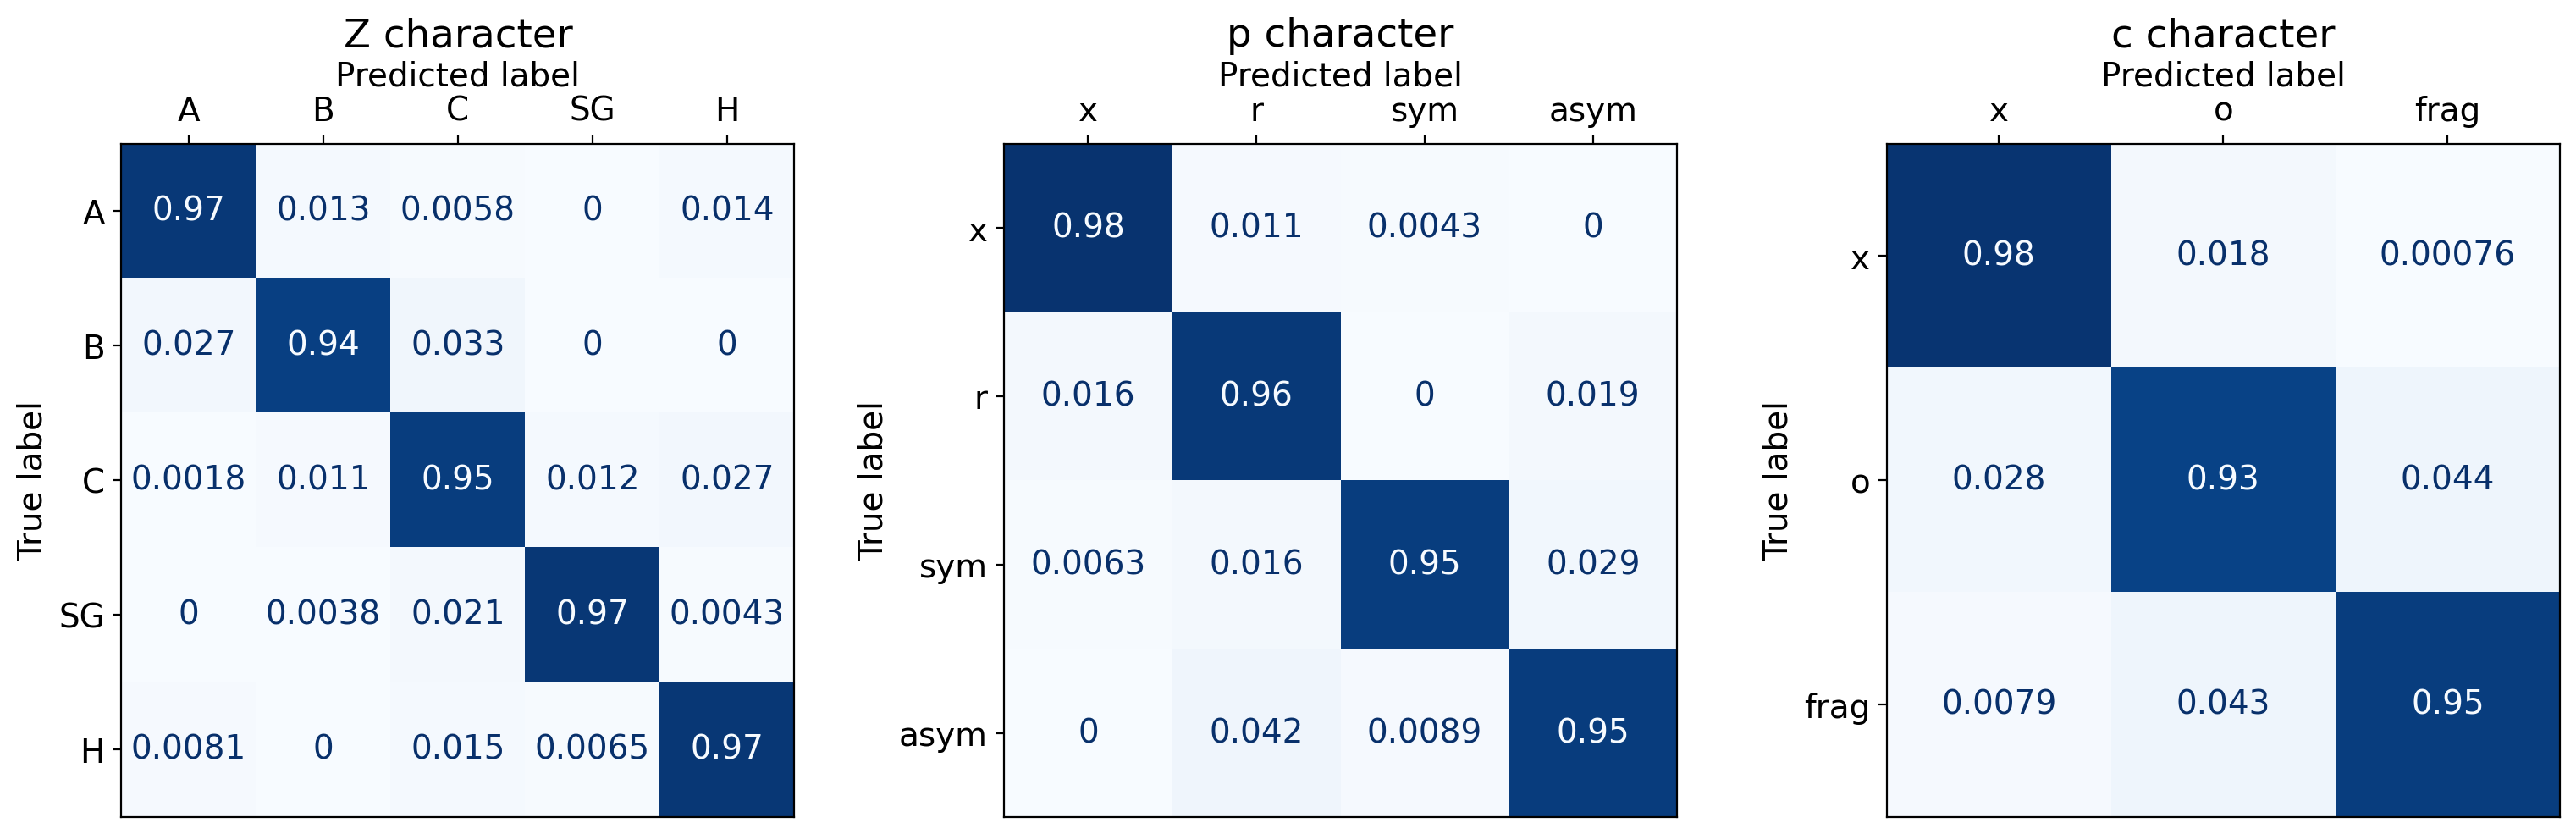

In [24]:
#code for y1
used_c1 = mapper["used_c1"]
c1_names  = list(used_c1.keys())
y1_true = c_agg_fed_y1_gt.values
y1_pred = c_agg_fed_y1_pred.values
conf_mat1 = confusion_matrix(y1_true,y1_pred, normalize='true')


disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1,
                                display_labels=c1_names,
                                )
#code for y2
used_c2 = mapper["used_c2"]
c2_names  = list(used_c2.keys())
y2_true = c_agg_fed_y2_gt.values
y2_pred = c_agg_fed_y2_pred.values
conf_mat2 = confusion_matrix(y2_true,y2_pred, normalize='true')

disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat2,
                                display_labels=c2_names,
)

#code for y3
used_c3 = mapper["used_c3"]
c3_names  = list(used_c3.keys())
y3_true = c_agg_fed_y3_gt.values
y3_pred = c_agg_fed_y3_pred.values
conf_mat3 = confusion_matrix(y3_true,y3_pred, normalize='true')

disp3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3,
                                display_labels=c3_names,
)

                            
                            
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33]} ,dpi=200)

# fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(6*2.6,5) , gridspec_kw={'width_ratios': [33,33,33, 1]} ,dpi=200)
# norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
# cb1 = matplotlib.colorbar.ColorbarBase(ax[3], cmap=plt.cm.Blues,
#                                 norm=norm,
#                                 orientation='vertical')

disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
# ax[0].imshow(conf_mat1)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
ax[0].set_title('Z character')
for im in ax[0].get_images():               
    im.set_clim(vmin=0,vmax=1)


disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
ax[1].xaxis.tick_top()
ax[1].xaxis.set_label_position('top')
ax[1].set_title('p character')
for im in ax[1].get_images():               
    im.set_clim(vmin=0,vmax=1)

disp3.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
ax[2].xaxis.tick_top()
ax[2].xaxis.set_label_position('top')
ax[2].set_title('c character')
for im in ax[2].get_images():               
    im.set_clim(vmin=0,vmax=1)

fig.tight_layout()
fig.show()

plt.savefig("VoteCorrect.pdf", format="pdf", bbox_inches="tight")

# Représenter ne nombre de majority vote correct en fct du nombre de fois ou la bonne classe a été votée

In [25]:
print(federated_y1_pred.shape)
corr_federated_y1_pred = federated_y1_pred['GT'] == federated_y1_pred['pred']
# get the corresponding rows in total_y1_pred
y1_fed_correct = total_y1_pred[corr_federated_y1_pred]

corr_federated_y2_pred = federated_y2_pred['GT'] == federated_y2_pred['pred']
# get the corresponding rows in total_y2_pred
y2_fed_correct = total_y2_pred[corr_federated_y2_pred]

corr_federated_y3_pred = federated_y3_pred['GT'] == federated_y3_pred['pred']
# get the corresponding rows in total_y3_pred
y3_fed_correct = total_y3_pred[corr_federated_y3_pred]

print(y1_fed_correct.shape)
print(y2_fed_correct.shape)
print(y3_fed_correct.shape)

(580, 2)
(400, 22)
(341, 22)
(421, 22)


In [28]:
y1_fed_correct

GT  run_21  run_22  run_23  run_24  run_25  run_26  run_27  run_28  \
1     3       3       3       3       3       3       3       3       3   
5     2       2       2       2       2       2       2       2       2   
6     1       1       1       1       1       1       0       1       0   
7     0       0       4       0       0       4       0       0       4   
9     3       3       3       3       3       3       3       3       3   
..   ..     ...     ...     ...     ...     ...     ...     ...     ...   
575   4       4       4       4       4       4       4       4       4   
576   4       4       4       4       4       4       4       4       4   
577   4       4       4       4       4       4       4       4       4   
578   4       4       4       4       4       4       4       4       4   
579   2       2       2       2       2       2       2       2       2   

     run_29  ...  run_32  run_33  run_34  run_35  run_36  run_37  run_38  \
1         3  ...       3       3       3       3       3       3       3   
5         2  ...       2       2       2       2       2       2       2   
6         1  ...       1       1       1       0       1       1       1   
7         0  ...       0       0       0       0       4       0       4   
9         3  ...       3       3       2       2       3       1       1   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
575       4  ...       4       4       4       4       4       4       4   
576       4  ...       4       4       4       4       4       4       4   
577       4  ...       4       4       4       4       4       4       4   
578       4  ...       4       4       4       4       4       4       4   
579       2  ...       2       2       2       2       2       2       2   

     run_39  run_40  pred  
1         3       3     3  
5         2       2     2  
6         1       1     1  
7         0       0     0  
9         3       3     3  
..      ...     ...   ...  
575       4       4     4  
576       4       4     4  
577       4       4     4  
578       4       4     4  
579       2       2     2  

[400 rows x 22 columns]

In [37]:
cur_runPreds_1 = y1_fed_correct[[f'run_{id}' for id in run_ids]]

counts = cur_runPreds_1.apply(lambda x: x.value_counts(), axis=1).fillna(0)

print(counts)
# y1_fed_correct = df.apply(pd.Series.value_counts, axis=1)[range(len(used_c1))].fillna(0)

        0     1     2     3     4
1     0.0   0.0   0.0  20.0   0.0
5     0.0   0.0  20.0   0.0   0.0
6     5.0  15.0   0.0   0.0   0.0
7    15.0   0.0   0.0   0.0   5.0
9     0.0   2.0   3.0  15.0   0.0
..    ...   ...   ...   ...   ...
575   0.0   0.0   0.0   0.0  20.0
576   0.0   0.0   0.0   0.0  20.0
577   0.0   0.0   0.0   0.0  20.0
578   0.0   0.0   0.0   0.0  20.0
579   0.0   0.0  20.0   0.0   0.0

[400 rows x 5 columns]


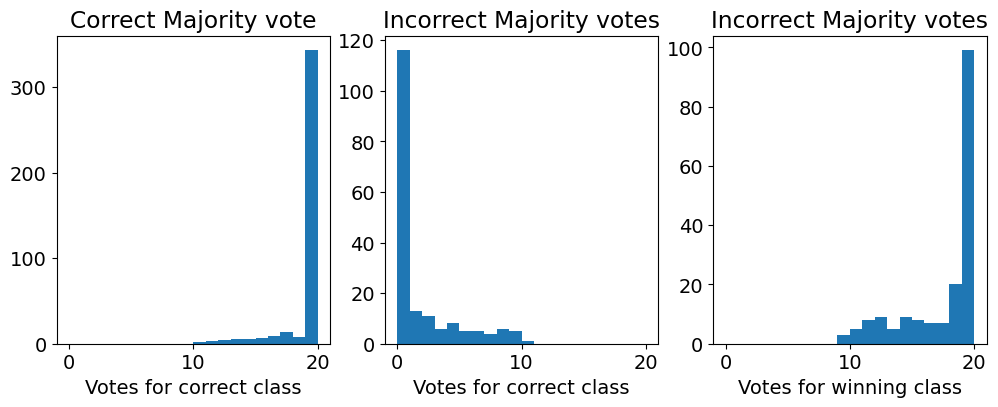

invalid value encountered in true_divide


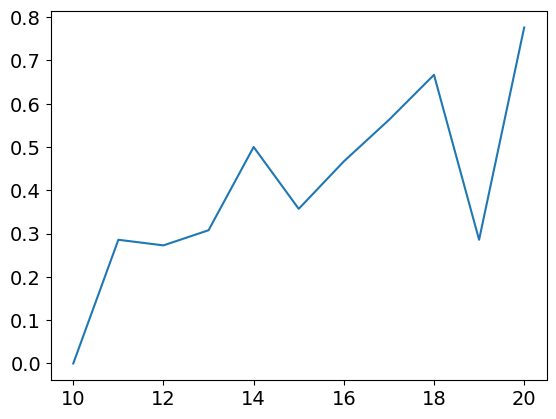

In [61]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

preds = total_y1_pred[[f'run_{id}' for id in run_ids]]
# count the number of times each value occurs in each row, if the it is not in the row, then it is 0
preds_counts = preds.apply(lambda x: x.value_counts(), axis=1).fillna(0)

# print('preds',preds_counts)

# create a new dataframe with the same index as df, one column , and values are random integers between 0 and 4
GT = total_y1_pred['GT'].copy()
GT = pd.DataFrame(GT.values, index=preds_counts.index, columns=['GT'])

# print('GT',GT)

# get the rows of preds where max value is in the GT column
correct = preds_counts.loc[preds_counts.idxmax(axis=1) == GT['GT']]
correct_gt = GT.loc[preds_counts.idxmax(axis=1) == GT['GT']]
# print(correct)

# get the rows of preds where max value is not in the GT column
incorrect = preds_counts.loc[preds_counts.idxmax(axis=1) != GT['GT']]
incorrect_gt = GT.loc[preds_counts.idxmax(axis=1) != GT['GT']]
# print('incorrect', incorrect)

# # for each row in correct, get the value of the column with the max value
correct_right_class = correct.max(axis=1).to_numpy()

# for each row in incorrect, get the value of the column in the GT column
np_incorrect = incorrect.to_numpy()
np_GT = incorrect_gt.to_numpy()
# print('np_incorrect', np_incorrect)
# print('np_GT', np_GT)
# for each row of np_incorrect, get the ith element of the row, where i value in np_GT
incorrect_right_class = np.zeros(len(np_incorrect))
for idx, gt in enumerate(np_GT):
    # print('idx', idx, 'gt', gt, 'np_incorrect[idx, gt]', np_incorrect[idx, gt])
    incorrect_right_class[idx] =  np_incorrect[idx, gt]
# print(incorrect_right_class)


incorrect_max = incorrect.max(axis=1).to_numpy()

# create bins for the histogram, there should be n+1 bins, where n is the number columns in preds
bins = np.arange(0, preds.shape[1]+1, 1)
# print(bins)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(correct_right_class, bins=bins)
# plt.hist(correct_right_class[correct_right_class<20], bins=bins)
plt.title('Correct Majority vote')
plt.xlabel('Votes for correct class')
plt.subplot(132)
# plt.hist(incorrect_right_class[incorrect_right_class>0], bins=bins)
plt.hist(incorrect_right_class, bins=bins)
plt.title('Incorrect Majority votes')
plt.xlabel('Votes for correct class')
plt.subplot(133)
plt.hist(incorrect_max, bins=bins)
plt.title('Incorrect Majority votes')
plt.xlabel('Votes for winning class')
plt.show()

correct_right_c ,_  = np.histogram(correct_right_class, bins=bins)
incorrect_right_c ,_= np.histogram(incorrect_right_class, bins=bins)
incorrect_max_c ,_ = np.histogram(incorrect_max, bins=bins)

ratio = correct_right_c / (correct_right_c + incorrect_max_c )

plt.figure()
plt.plot(bins[1:],ratio)
plt.show()
